Cargadas 20 imágenes de /home/bllancao/Portafolio/mvtec_anomaly_detection/data/raw/bottle/train/good
MVTec AD Anomaly Detection con DINOv2

Extractor creado - Capa: -1, Device: cpu

------------------------------------------------------------
MÉTODO 1: Dense Matching (Posicional)
------------------------------------------------------------
Mapa de anomalía shape: (16, 16)
Score máximo: 0.6398


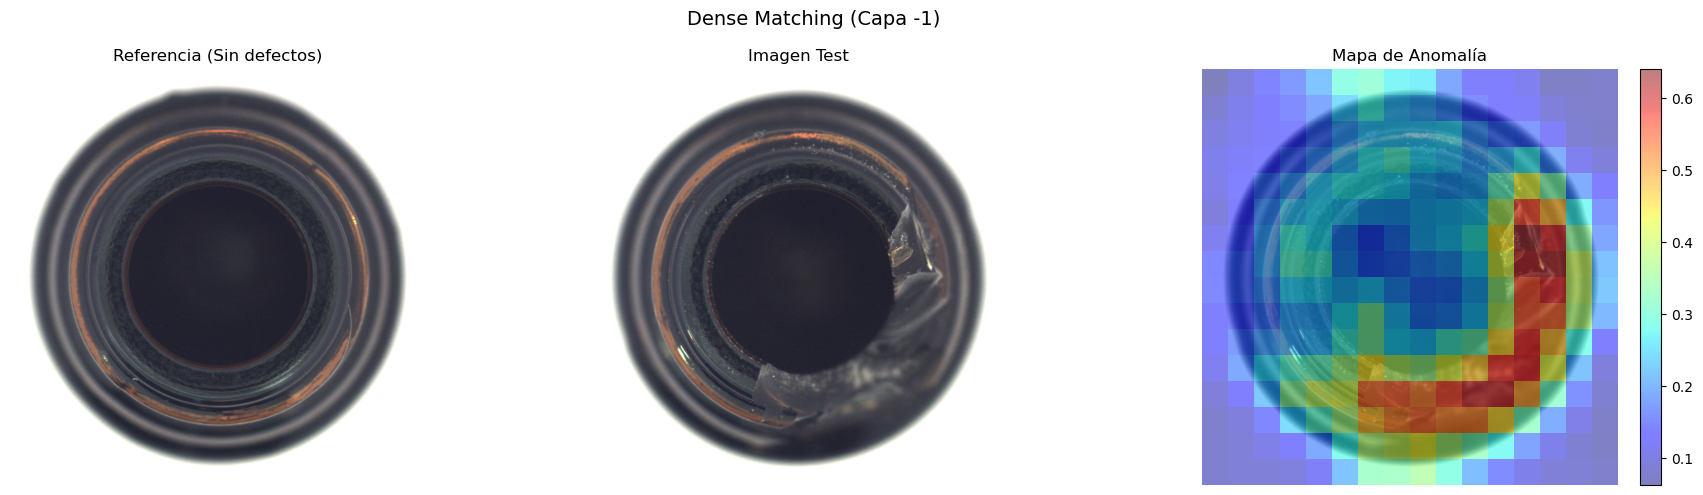


------------------------------------------------------------
MÉTODO 2: Memory Bank + k-NN (PatchCore-style)
------------------------------------------------------------

Construyendo Memory Bank...
Procesadas 10/20 imágenes
Procesadas 20/20 imágenes
Memory Bank construido: 5120 patches, dim=768
Mapa de anomalía shape: (16, 16)
Score de imagen: 0.4367


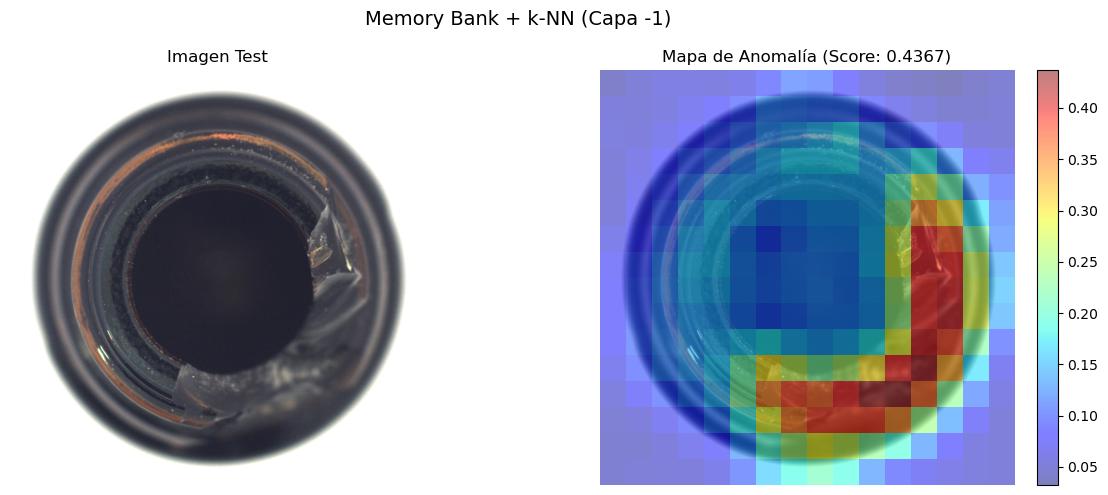


EVALUACIÓN CON GROUND TRUTH
Cargados 5 pares (test, ground_truth) de /home/bllancao/Portafolio/mvtec_anomaly_detection/data/raw/bottle/test/broken_large

📍 Evaluando: 000.png


/tmp/ipykernel_223885/4173124958.py:902: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  au_pro = np.trapz(pro_sorted, fpr_sorted) / fpr_limit


   📊 Valores Originales: min=0.032345, max=0.436703, mean=0.153401
   📊 Normalizado: Sí → umbral 0.50 aplicado sobre [0, 1]
   📈 IoU: 0.5952 | Dice: 0.7462 | F1: 0.7462 | AU-PRO: 0.8891


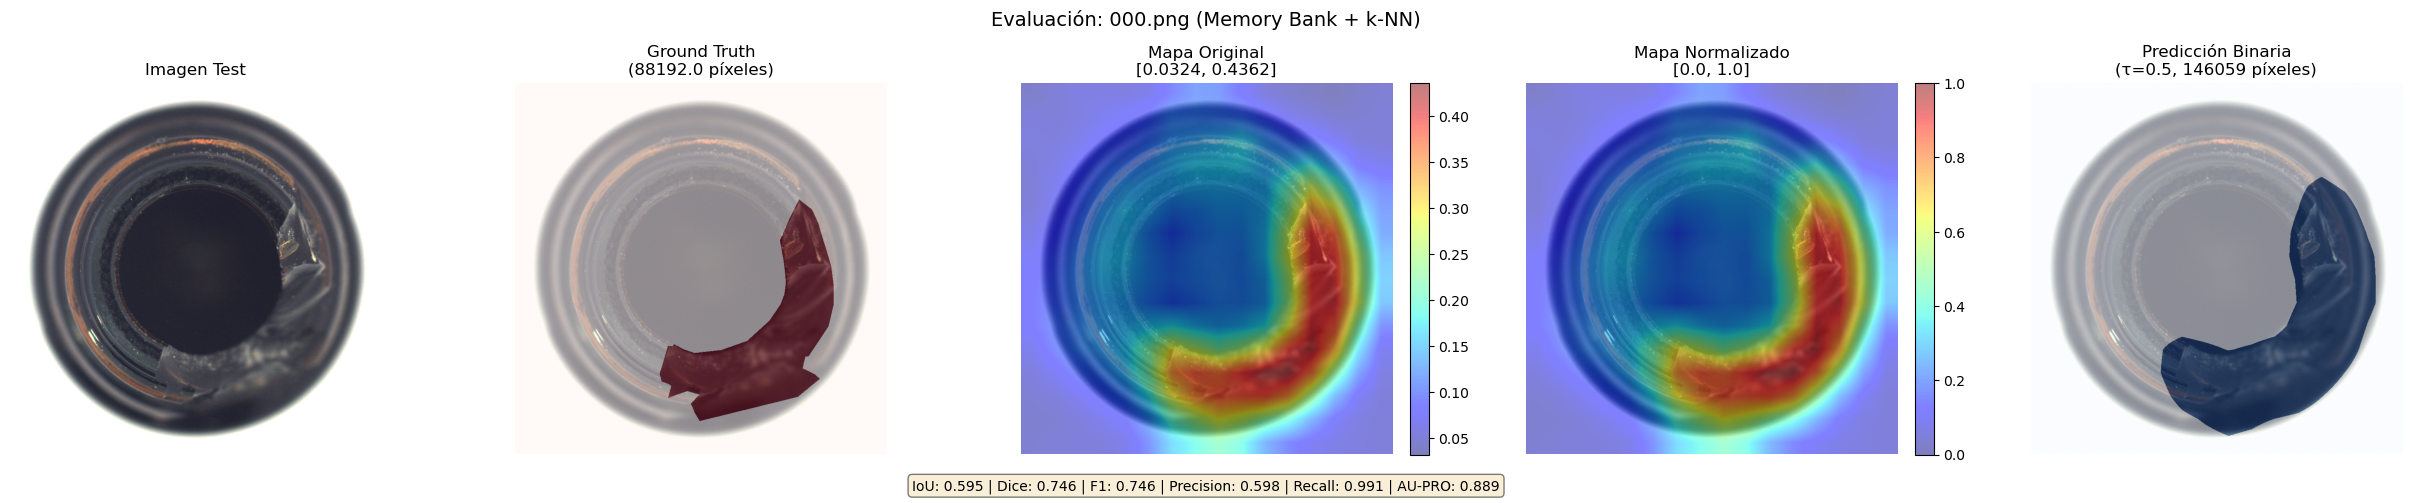


📍 Evaluando: 001.png
   📊 Valores Originales: min=0.049937, max=0.426235, mean=0.172491
   📊 Normalizado: Sí → umbral 0.50 aplicado sobre [0, 1]
   📈 IoU: 0.4203 | Dice: 0.5919 | F1: 0.5919 | AU-PRO: 0.8580

📍 Evaluando: 002.png
   📊 Valores Originales: min=0.041567, max=0.451550, mean=0.182613
   📊 Normalizado: Sí → umbral 0.50 aplicado sobre [0, 1]
   📈 IoU: 0.5822 | Dice: 0.7360 | F1: 0.7360 | AU-PRO: 0.8537

📍 Evaluando: 003.png
   📊 Valores Originales: min=0.090214, max=0.431630, mean=0.260583
   📊 Normalizado: Sí → umbral 0.50 aplicado sobre [0, 1]
   📈 IoU: 0.5683 | Dice: 0.7247 | F1: 0.7247 | AU-PRO: 0.7824

📍 Evaluando: 004.png
   📊 Valores Originales: min=0.022001, max=0.425909, mean=0.093368
   📊 Normalizado: Sí → umbral 0.50 aplicado sobre [0, 1]
   📈 IoU: 0.4795 | Dice: 0.6482 | F1: 0.6482 | AU-PRO: 0.9324

------------------------------------------------------------
RESUMEN DE MÉTRICAS
------------------------------------------------------------

📊 Estadísticas de Mapas 

In [11]:
"""
MVTec AD Anomaly Detection con DINOv2
=====================================

Dos métodos optimizados para MVTec AD (imágenes alineadas):
1. Dense Matching (Posicional) - Comparación 1:1 entre patches
2. Memory Bank + k-NN (PatchCore-style) - Estado del arte

Ambos métodos permiten configurar la capa de extracción de features.
"""

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import torch
import torch.nn.functional as F
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import scipy.ndimage as ndimage
from typing import List, Optional, Tuple, Union
import cv2
import warnings


# =============================================================================
# FUNCIONES DE NORMALIZACIÓN Y RESIZE
# =============================================================================

def normalize_anomaly_map(
    anomaly_map: np.ndarray,
    method: str = 'minmax',
    clip_percentile: Optional[Tuple[float, float]] = None,
    robust_percentile: Tuple[float, float] = (2, 98)
) -> np.ndarray:
    """
    Normaliza un mapa de anomalía al rango [0, 1].
    
    Args:
        anomaly_map: Mapa de anomalía [H, W] con valores continuos
        method: Método de normalización:
            - 'minmax': Normalización min-max estándar
            - 'robust': Normalización robusta usando percentiles (evita outliers)
        clip_percentile: Tupla (min_percentile, max_percentile) para recortar
                        valores extremos antes de normalizar. Ej: (1, 99)
        robust_percentile: Percentiles a usar para normalización robusta.
                          Por defecto (2, 98)
    
    Returns:
        normalized_map: Mapa normalizado en [0, 1]
    
    Example:
        >>> amap = normalize_anomaly_map(raw_scores, method='robust')
        >>> amap = normalize_anomaly_map(raw_scores, clip_percentile=(1, 99))
    """
    amap = anomaly_map.astype(np.float32).copy()
    
    # Paso 1: Recortar valores extremos si se especifica
    if clip_percentile is not None:
        p_min, p_max = clip_percentile
        v_min = np.percentile(amap, p_min)
        v_max = np.percentile(amap, p_max)
        amap = np.clip(amap, v_min, v_max)
    
    # Paso 2: Normalizar según el método
    if method == 'minmax':
        # Normalización min-max estándar
        amap_min = amap.min()
        amap_max = amap.max()
        
        if amap_max > amap_min:
            normalized = (amap - amap_min) / (amap_max - amap_min)
        else:
            # Mapa uniforme, retornar ceros
            normalized = np.zeros_like(amap)
            warnings.warn("Mapa de anomalía tiene valores uniformes (min == max)")
    
    elif method == 'robust':
        # Normalización robusta usando percentiles
        p_low, p_high = robust_percentile
        v_low = np.percentile(amap, p_low)
        v_high = np.percentile(amap, p_high)
        
        if v_high > v_low:
            normalized = (amap - v_low) / (v_high - v_low)
            normalized = np.clip(normalized, 0, 1)
        else:
            normalized = np.zeros_like(amap)
            warnings.warn("Percentiles robustos iguales, usando normalización min-max")
            return normalize_anomaly_map(amap, method='minmax')
    else:
        raise ValueError(f"Método de normalización no válido: {method}. Usar 'minmax' o 'robust'")
    
    return normalized


def resize_anomaly_map(
    anomaly_map: np.ndarray,
    target_size: Tuple[int, int],
    interpolation: str = 'bilinear'
) -> np.ndarray:
    """
    Redimensiona un mapa de anomalía a un tamaño objetivo.
    
    Args:
        anomaly_map: Mapa de anomalía [H, W]
        target_size: Tamaño objetivo (height, width)
        interpolation: Método de interpolación:
            - 'bilinear': Interpolación bilinear (suave, por defecto)
            - 'nearest': Vecino más cercano (preserva valores exactos)
            - 'cubic': Interpolación bicúbica (más suave)
    
    Returns:
        resized_map: Mapa redimensionado [target_H, target_W]
    """
    interp_methods = {
        'bilinear': cv2.INTER_LINEAR,
        'nearest': cv2.INTER_NEAREST,
        'cubic': cv2.INTER_CUBIC
    }
    
    if interpolation not in interp_methods:
        raise ValueError(f"Interpolación no válida: {interpolation}. Usar: {list(interp_methods.keys())}")
    
    # cv2.resize espera (width, height)
    target_wh = (target_size[1], target_size[0])
    
    resized = cv2.resize(
        anomaly_map.astype(np.float32),
        target_wh,
        interpolation=interp_methods[interpolation]
    )
    
    return resized


# =============================================================================
# CONFIGURACIÓN DEL MODELO
# =============================================================================

class DINOv2FeatureExtractor:
    """
    Extractor de features con DINOv2 y capa configurable.
    
    Args:
        model_path: Ruta al modelo DINOv2
        layer_idx: Índice de la capa a usar (-1 = última, 0 = embedding, etc.)
        device: Dispositivo para inferencia ('cuda' o 'cpu')
    """
    
    def __init__(self, model_path: str, layer_idx: int = -1, device: str = None):
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.processor = AutoImageProcessor.from_pretrained(model_path)
        self.model = AutoModel.from_pretrained(model_path).to(self.device)
        self.model.eval()
        self.layer_idx = layer_idx
        
        # DINOv2-base usa patches de 14x14
        self.patch_size = 14
        
    def extract_patches(self, image: Image.Image, normalize: bool = True) -> torch.Tensor:
        """
        Extrae embeddings de patches de una imagen.
        
        Args:
            image: Imagen PIL
            normalize: Si True, normaliza los embeddings (L2)
            
        Returns:
            patches: Tensor [num_patches, hidden_dim]
        """
        inputs = self.processor(images=image, return_tensors="pt", do_rescale=True).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs, output_hidden_states=True)
            
            # Seleccionar capa específica
            if self.layer_idx == -1:
                # Última capa (last_hidden_state)
                hidden_states = outputs.last_hidden_state
            else:
                # Capa específica de hidden_states
                hidden_states = outputs.hidden_states[self.layer_idx]
            
            # Remover token CLS (primer token)
            patches = hidden_states[:, 1:, :].squeeze(0)  # [num_patches, hidden_dim]
            
            if normalize:
                patches = F.normalize(patches, p=2, dim=-1)
                
        return patches
    
    def extract_patches_batch(self, images: List[Image.Image], normalize: bool = True) -> torch.Tensor:
        """
        Extrae patches de múltiples imágenes en batch.
        
        Returns:
            patches: Tensor [batch, num_patches, hidden_dim]
        """
        inputs = self.processor(images=images, return_tensors="pt", do_rescale=True).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs, output_hidden_states=True)
            
            if self.layer_idx == -1:
                hidden_states = outputs.last_hidden_state
            else:
                hidden_states = outputs.hidden_states[self.layer_idx]
            
            patches = hidden_states[:, 1:, :]  # [batch, num_patches, hidden_dim]
            
            if normalize:
                patches = F.normalize(patches, p=2, dim=-1)
                
        return patches
    
    def get_grid_size(self, image: Image.Image) -> Tuple[int, int]:
        """Retorna el tamaño del grid de patches (h, w)."""
        inputs = self.processor(images=image, return_tensors="pt")
        h = inputs['pixel_values'].shape[-2] // self.patch_size
        w = inputs['pixel_values'].shape[-1] // self.patch_size
        return h, w


# =============================================================================
# MÉTODO 1: DENSE MATCHING (POSICIONAL)
# =============================================================================

class DenseMatchingDetector:
    """
    Detector de anomalías por Dense Matching (correspondencia posicional 1:1).
    
    Ideal para MVTec AD donde las imágenes están bien alineadas.
    Compara cada patch de la imagen test con el patch en la misma posición
    de la imagen de referencia.
    
    Args:
        extractor: Instancia de DINOv2FeatureExtractor
    """
    
    def __init__(self, extractor: DINOv2FeatureExtractor):
        self.extractor = extractor
        
    def compute_anomaly_map(
        self, 
        test_image: Image.Image, 
        reference_image: Image.Image,
        smooth_sigma: float = 0.8
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Calcula mapa de anomalía por comparación posicional 1:1.
        
        Args:
            test_image: Imagen a evaluar
            reference_image: Imagen de referencia (sin defectos)
            smooth_sigma: Sigma para suavizado Gaussiano
            
        Returns:
            anomaly_map: Mapa de anomalía [H, W] sin suavizar
            anomaly_map_smooth: Mapa de anomalía [H, W] suavizado
        """
        # Extraer patches de ambas imágenes
        test_patches = self.extractor.extract_patches(test_image)      # [N, D]
        ref_patches = self.extractor.extract_patches(reference_image)  # [N, D]
        
        # Similitud coseno por patch (correspondencia posicional)
        cosine_sim = (test_patches * ref_patches).sum(dim=-1)  # [N]
        
        # Anomalía = 1 - similitud
        anomaly_scores = (1 - cosine_sim).cpu().numpy()
        
        # Reshape a grid 2D
        h, w = self.extractor.get_grid_size(test_image)
        anomaly_map = anomaly_scores.reshape(h, w)
        
        # Suavizado
        anomaly_map_smooth = ndimage.gaussian_filter(anomaly_map, sigma=smooth_sigma)
        
        return anomaly_map, anomaly_map_smooth
    
    def compute_anomaly_map_multi_ref(
        self,
        test_image: Image.Image,
        reference_images: List[Image.Image],
        aggregation: str = 'min',
        smooth_sigma: float = 0.8
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Calcula mapa de anomalía contra múltiples referencias.
        
        Args:
            test_image: Imagen a evaluar
            reference_images: Lista de imágenes de referencia
            aggregation: 'min' (menor distancia) o 'mean' (promedio)
            smooth_sigma: Sigma para suavizado
            
        Returns:
            anomaly_map, anomaly_map_smooth
        """
        test_patches = self.extractor.extract_patches(test_image)  # [N, D]
        
        all_scores = []
        for ref_img in reference_images:
            ref_patches = self.extractor.extract_patches(ref_img)
            cosine_sim = (test_patches * ref_patches).sum(dim=-1)
            scores = 1 - cosine_sim
            all_scores.append(scores)
        
        all_scores = torch.stack(all_scores, dim=0)  # [num_refs, N]
        
        if aggregation == 'min':
            anomaly_scores = all_scores.min(dim=0)[0]
        else:
            anomaly_scores = all_scores.mean(dim=0)
        
        h, w = self.extractor.get_grid_size(test_image)
        anomaly_map = anomaly_scores.cpu().numpy().reshape(h, w)
        anomaly_map_smooth = ndimage.gaussian_filter(anomaly_map, sigma=smooth_sigma)
        
        return anomaly_map, anomaly_map_smooth
    
    def visualize(
        self,
        test_image: Image.Image,
        reference_image: Image.Image,
        anomaly_map: np.ndarray,
        title: str = "Dense Matching - Detección de Anomalías"
    ):
        """Visualiza resultado de detección."""
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        axes[0].imshow(reference_image)
        axes[0].set_title("Referencia (Sin defectos)")
        axes[0].axis('off')
        
        axes[1].imshow(test_image)
        axes[1].set_title("Imagen Test")
        axes[1].axis('off')
        
        axes[2].imshow(test_image)
        im = axes[2].imshow(
            anomaly_map, 
            cmap='jet', 
            alpha=0.5, 
            extent=(0, test_image.width, test_image.height, 0)
        )
        axes[2].set_title("Mapa de Anomalía")
        axes[2].axis('off')
        plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
        
        plt.suptitle(title, fontsize=14)
        plt.tight_layout()
        plt.show()
        
        return fig


# =============================================================================
# MÉTODO 2: MEMORY BANK + k-NN (PATCHCORE-STYLE)
# =============================================================================

class MemoryBankDetector:
    """
    Detector de anomalías estilo PatchCore con Memory Bank + k-NN.
    
    Estado del arte para MVTec AD. Construye un banco de memoria con
    patches de imágenes normales y detecta anomalías buscando patches
    que no tienen vecinos cercanos en el banco.
    
    Args:
        extractor: Instancia de DINOv2FeatureExtractor
        k: Número de vecinos más cercanos para scoring
        coreset_ratio: Ratio de subsampling del memory bank (1.0 = sin subsampling)
    """
    
    def __init__(
        self, 
        extractor: DINOv2FeatureExtractor, 
        k: int = 1,
        coreset_ratio: float = 1.0
    ):
        self.extractor = extractor
        self.k = k
        self.coreset_ratio = coreset_ratio
        self.memory_bank = None
        
    def build_memory_bank(self, good_images: List[Image.Image], verbose: bool = True):
        """
        Construye el banco de memoria con patches de imágenes sin defectos.
        
        Args:
            good_images: Lista de imágenes PIL sin defectos (training set)
            verbose: Si True, muestra progreso
        """
        all_patches = []
        
        for i, img in enumerate(good_images):
            patches = self.extractor.extract_patches(img)  # [N, D]
            all_patches.append(patches)
            
            if verbose and (i + 1) % 10 == 0:
                print(f"Procesadas {i + 1}/{len(good_images)} imágenes")
        
        # Concatenar todos los patches
        self.memory_bank = torch.cat(all_patches, dim=0)  # [total_patches, D]
        
        # Coreset subsampling (opcional, para reducir memoria)
        if self.coreset_ratio < 1.0:
            n_samples = int(len(self.memory_bank) * self.coreset_ratio)
            indices = torch.randperm(len(self.memory_bank))[:n_samples]
            self.memory_bank = self.memory_bank[indices]
        
        if verbose:
            print(f"Memory Bank construido: {self.memory_bank.shape[0]} patches, "
                  f"dim={self.memory_bank.shape[1]}")
    
    def compute_anomaly_map(
        self, 
        test_image: Image.Image,
        smooth_sigma: float = 0.8
    ) -> Tuple[np.ndarray, np.ndarray, float]:
        """
        Calcula mapa de anomalía comparando contra memory bank.
        
        Args:
            test_image: Imagen a evaluar
            smooth_sigma: Sigma para suavizado
            
        Returns:
            anomaly_map: Mapa [H, W] sin suavizar
            anomaly_map_smooth: Mapa [H, W] suavizado
            image_score: Score de anomalía a nivel de imagen
        """
        if self.memory_bank is None:
            raise RuntimeError("Primero ejecuta build_memory_bank()")
        
        # Extraer patches de imagen test
        test_patches = self.extractor.extract_patches(test_image)  # [N, D]
        
        # Calcular similitud con todo el memory bank
        # sim[i, j] = similitud entre test_patch[i] y memory_patch[j]
        sim_matrix = torch.mm(test_patches, self.memory_bank.t())  # [N, memory_size]
        
        # k-NN: obtener k vecinos más similares
        topk_sim, _ = sim_matrix.topk(self.k, dim=1)  # [N, k]
        
        # Anomalía = 1 - similitud promedio de k vecinos
        anomaly_scores = 1 - topk_sim.mean(dim=1)  # [N]
        
        # Reshape a grid 2D
        h, w = self.extractor.get_grid_size(test_image)
        anomaly_map = anomaly_scores.cpu().numpy().reshape(h, w)
        
        # Suavizado
        anomaly_map_smooth = ndimage.gaussian_filter(anomaly_map, sigma=smooth_sigma)
        
        # Score a nivel de imagen (máximo score de anomalía)
        image_score = anomaly_map_smooth.max()
        
        return anomaly_map, anomaly_map_smooth, image_score
    
    def predict_batch(
        self,
        test_images: List[Image.Image],
        smooth_sigma: float = 0.8
    ) -> Tuple[List[np.ndarray], List[float]]:
        """
        Predice anomalías para un batch de imágenes.
        
        Returns:
            anomaly_maps: Lista de mapas de anomalía
            image_scores: Lista de scores por imagen
        """
        anomaly_maps = []
        image_scores = []
        
        for img in test_images:
            _, amap_smooth, score = self.compute_anomaly_map(img, smooth_sigma)
            anomaly_maps.append(amap_smooth)
            image_scores.append(score)
        
        return anomaly_maps, image_scores
    
    def visualize(
        self,
        test_image: Image.Image,
        anomaly_map: np.ndarray,
        image_score: float,
        title: str = "Memory Bank + k-NN - Detección de Anomalías"
    ):
        """Visualiza resultado de detección."""
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        axes[0].imshow(test_image)
        axes[0].set_title("Imagen Test")
        axes[0].axis('off')
        
        axes[1].imshow(test_image)
        im = axes[1].imshow(
            anomaly_map, 
            cmap='jet', 
            alpha=0.5, 
            extent=(0, test_image.width, test_image.height, 0)
        )
        axes[1].set_title(f"Mapa de Anomalía (Score: {image_score:.4f})")
        axes[1].axis('off')
        plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
        
        plt.suptitle(title, fontsize=14)
        plt.tight_layout()
        plt.show()
        
        return fig


# =============================================================================
# UTILIDADES DE VISUALIZACIÓN
# =============================================================================

def visualize_layer_comparison(
    extractor: DINOv2FeatureExtractor,
    image: Image.Image,
    layers_to_compare: List[int] = [0, 3, 6, 9, 12, -1]
):
    """
    Compara visualización PCA de diferentes capas del modelo.
    
    Útil para elegir la capa óptima para extracción de features.
    """
    original_layer = extractor.layer_idx
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for ax, layer_idx in zip(axes, layers_to_compare):
        extractor.layer_idx = layer_idx
        patches = extractor.extract_patches(image, normalize=False).cpu().numpy()
        
        # PCA a 3 componentes para RGB
        pca = PCA(n_components=3)
        pca_result = pca.fit_transform(patches)
        
        # Normalizar a [0, 1]
        pca_min = pca_result.min(axis=0)
        pca_max = pca_result.max(axis=0)
        pca_norm = (pca_result - pca_min) / (pca_max - pca_min + 1e-8)
        
        h, w = extractor.get_grid_size(image)
        pca_image = pca_norm.reshape(h, w, 3)
        
        layer_name = "Última" if layer_idx == -1 else str(layer_idx)
        ax.imshow(pca_image)
        ax.set_title(f"Capa {layer_name}")
        ax.axis('off')
    
    extractor.layer_idx = original_layer
    plt.suptitle("Comparación de Features por Capa (PCA→RGB)", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return fig


def upsample_anomaly_map(
    anomaly_map: np.ndarray,
    target_size: Tuple[int, int],
    mode: str = 'bilinear'
) -> np.ndarray:
    """
    Escala el mapa de anomalía al tamaño de la imagen original.
    
    Args:
        anomaly_map: Mapa de anomalía [H, W]
        target_size: (height, width) objetivo
        mode: 'bilinear' o 'nearest'
    """
    amap_tensor = torch.from_numpy(anomaly_map).unsqueeze(0).unsqueeze(0).float()
    
    # align_corners solo para modos que lo soporten
    if mode in ('nearest', 'area'):
        upsampled = F.interpolate(amap_tensor, size=target_size, mode=mode)
    else:
        upsampled = F.interpolate(amap_tensor, size=target_size, mode=mode, align_corners=False)
    
    return upsampled.squeeze().numpy()


# =============================================================================
# MÉTRICAS DE EVALUACIÓN
# =============================================================================

class AnomalyEvaluator:
    """
    Evaluador de métricas para detección de anomalías.
    
    Calcula métricas pixel-level y region-level comparando
    mapas de anomalía predichos contra ground truth masks.
    
    Métricas implementadas:
    - Pixel-level: IoU, Dice, Precision, Recall, F1
    - Region-level: PRO (Per-Region Overlap)
    
    Características mejoradas:
    - auto_normalize: Normalización automática al rango [0, 1]
    - Resize automático al tamaño del ground truth
    - Estadísticas de diagnóstico en resultados
    """
    
    def __init__(self, threshold: float = 0.5, auto_normalize: bool = True):
        """
        Args:
            threshold: Umbral para binarizar el mapa de anomalía (0-1).
                      Se aplica DESPUÉS de normalizar al rango [0, 1].
            auto_normalize: Si True, normaliza automáticamente el mapa
                           al rango [0, 1] antes de aplicar el umbral.
        """
        self.threshold = threshold
        self.auto_normalize = auto_normalize
    
    @staticmethod
    def load_ground_truth(gt_path: str) -> np.ndarray:
        """
        Carga una máscara ground truth como array binario.
        
        Args:
            gt_path: Ruta a la imagen de ground truth
            
        Returns:
            mask: Array binario [H, W] con valores 0 o 1
        """
        gt_image = Image.open(gt_path).convert('L')
        gt_array = np.array(gt_image)
        # Binarizar (MVTec usa 255 para anomalía, 0 para normal)
        return (gt_array > 127).astype(np.float32)
    
    def binarize_anomaly_map(
        self, 
        anomaly_map: np.ndarray, 
        threshold: float = None
    ) -> np.ndarray:
        """
        Binariza un mapa de anomalía usando el umbral.
        
        Args:
            anomaly_map: Mapa de anomalía [H, W] con valores en [0, 1]
            threshold: Umbral (usa self.threshold si es None)
            
        Returns:
            binary_mask: Máscara binaria [H, W]
        """
        if threshold is None:
            threshold = self.threshold
        
        # Normalizar a [0, 1] si es necesario
        amap_min = anomaly_map.min()
        amap_max = anomaly_map.max()
        if amap_max > amap_min:
            normalized = (anomaly_map - amap_min) / (amap_max - amap_min)
        else:
            normalized = np.zeros_like(anomaly_map)
        
        return (normalized >= threshold).astype(np.float32)
    
    # -------------------------------------------------------------------------
    # PIXEL-LEVEL METRICS
    # -------------------------------------------------------------------------
    
    def compute_pixel_metrics(
        self, 
        pred_mask: np.ndarray, 
        gt_mask: np.ndarray
    ) -> dict:
        """
        Calcula métricas a nivel de pixel.
        
        Args:
            pred_mask: Máscara predicha binaria [H, W]
            gt_mask: Ground truth binario [H, W]
            
        Returns:
            dict con: IoU, Dice, Precision, Recall, F1
        """
        # Asegurar mismo tamaño
        if pred_mask.shape != gt_mask.shape:
            pred_mask = upsample_anomaly_map(
                pred_mask, 
                target_size=gt_mask.shape,
                mode='nearest'
            )
        
        pred = pred_mask.flatten().astype(bool)
        gt = gt_mask.flatten().astype(bool)
        
        # Componentes de la matriz de confusión
        tp = np.sum(pred & gt)        # True Positives
        fp = np.sum(pred & ~gt)       # False Positives
        fn = np.sum(~pred & gt)       # False Negatives
        tn = np.sum(~pred & ~gt)      # True Negatives
        
        # Métricas
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        
        intersection = tp
        union = tp + fp + fn
        iou = intersection / union if union > 0 else 0.0
        
        dice = 2 * intersection / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0.0
        
        return {
            'IoU': iou,
            'Dice': dice,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'TP': int(tp),
            'FP': int(fp),
            'FN': int(fn),
            'TN': int(tn)
        }
    
    # -------------------------------------------------------------------------
    # REGION-LEVEL METRICS (PRO)
    # -------------------------------------------------------------------------
    
    def compute_pro_single(
        self,
        pred_mask: np.ndarray,
        gt_mask: np.ndarray
    ) -> Tuple[float, int, List[float]]:
        """
        Calcula PRO para una sola imagen con un umbral fijo.
        
        Fórmula del paper:
        PRO = (1/N) * Σ_i Σ_k (|P_i ∩ C_{i,k}| / |C_{i,k}|)
        
        Donde:
        - N = número total de regiones conectadas en el ground truth
        - C_{i,k} = píxeles del componente k en imagen i
        - P_i = píxeles predichos como anómalos
        
        Args:
            pred_mask: Máscara binaria de predicción [H, W]
            gt_mask: Ground truth binario [H, W]
            
        Returns:
            pro_score: Score PRO para esta imagen (promedio sobre regiones)
            num_regions: Número de regiones conectadas
            region_overlaps: Lista de overlaps por región
        """
        from scipy import ndimage as ndi
        
        # Asegurar mismo tamaño
        if pred_mask.shape != gt_mask.shape:
            pred_mask = upsample_anomaly_map(
                pred_mask,
                target_size=gt_mask.shape,
                mode='nearest'
            )
        
        # Encontrar regiones conectadas en ground truth
        labeled_gt, num_regions = ndi.label(gt_mask > 0)
        
        if num_regions == 0:
            return 1.0, 0, []
        
        # Calcular overlap para cada región: |P ∩ C_k| / |C_k|
        region_overlaps = []
        pred_binary = pred_mask > 0
        
        for region_id in range(1, num_regions + 1):
            region_mask = (labeled_gt == region_id)
            region_size = np.sum(region_mask)  # |C_k|
            
            if region_size > 0:
                intersection = np.sum(pred_binary & region_mask)  # |P ∩ C_k|
                overlap = intersection / region_size
                region_overlaps.append(overlap)
        
        # PRO para esta imagen = promedio sobre regiones
        pro_score = np.mean(region_overlaps) if region_overlaps else 0.0
        
        return pro_score, num_regions, region_overlaps
    
    def compute_pro(
        self, 
        anomaly_map: np.ndarray, 
        gt_mask: np.ndarray,
        threshold: float = None
    ) -> Tuple[float, int, List[float]]:
        """
        Calcula PRO para un mapa de anomalía usando un umbral.
        
        Args:
            anomaly_map: Mapa de anomalía [H, W] (valores continuos)
            gt_mask: Ground truth binario [H, W]
            threshold: Umbral para binarizar (usa self.threshold si None)
            
        Returns:
            pro_score: Score PRO
            num_regions: Número de regiones
            region_overlaps: Overlaps por región
        """
        # Binarizar mapa de anomalía
        pred_mask = self.binarize_anomaly_map(anomaly_map, threshold)
        return self.compute_pro_single(pred_mask, gt_mask)
    
    def compute_au_pro(
        self, 
        anomaly_map: np.ndarray, 
        gt_mask: np.ndarray,
        num_thresholds: int = 100,
        fpr_limit: float = 0.3
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, float]:
        """
        Calcula AU-PRO (Area Under PRO curve).
        
        Calcula la curva PRO vs FPR para múltiples umbrales y el área
        bajo la curva hasta un límite de FPR (típicamente 0.3).
        
        Args:
            anomaly_map: Mapa de anomalía [H, W] (valores continuos)
            gt_mask: Ground truth binario [H, W]
            num_thresholds: Número de umbrales para la curva
            fpr_limit: Límite de FPR para integración (default 0.3)
            
        Returns:
            thresholds: Umbrales usados
            fpr_values: FPR para cada umbral
            pro_values: PRO para cada umbral
            au_pro: Área bajo la curva PRO normalizada
        """
        from scipy import ndimage as ndi
        
        # Asegurar mismo tamaño
        if anomaly_map.shape != gt_mask.shape:
            anomaly_map = upsample_anomaly_map(
                anomaly_map, 
                target_size=gt_mask.shape,
                mode='bilinear'
            )
        
        # Normalizar mapa a [0, 1]
        amap_min = anomaly_map.min()
        amap_max = anomaly_map.max()
        if amap_max > amap_min:
            anomaly_map_norm = (anomaly_map - amap_min) / (amap_max - amap_min)
        else:
            anomaly_map_norm = np.zeros_like(anomaly_map)
        
        # Encontrar regiones conectadas en ground truth
        labeled_gt, num_regions = ndi.label(gt_mask > 0)
        
        if num_regions == 0:
            return np.array([0.0]), np.array([0.0]), np.array([1.0]), 1.0
        
        # Calcular PRO y FPR para múltiples umbrales
        thresholds = np.linspace(0, 1, num_thresholds)
        fpr_values = []
        pro_values = []
        
        total_normal_pixels = np.sum(gt_mask == 0)
        
        for thresh in thresholds:
            pred_mask = (anomaly_map_norm >= thresh)
            
            # FPR: False Positive Rate en píxeles normales
            if total_normal_pixels > 0:
                fp = np.sum(pred_mask & (gt_mask == 0))
                fpr = fp / total_normal_pixels
            else:
                fpr = 0.0
            
            # PRO: (1/N) * Σ_k (|P ∩ C_k| / |C_k|)
            region_overlaps = []
            for region_id in range(1, num_regions + 1):
                region_mask = (labeled_gt == region_id)
                region_size = np.sum(region_mask)
                
                if region_size > 0:
                    intersection = np.sum(pred_mask & region_mask)
                    overlap = intersection / region_size
                    region_overlaps.append(overlap)
            
            pro = np.mean(region_overlaps) if region_overlaps else 0.0
            
            fpr_values.append(fpr)
            pro_values.append(pro)
        
        thresholds = np.array(thresholds)
        fpr_values = np.array(fpr_values)
        pro_values = np.array(pro_values)
        
        # Calcular AU-PRO (área bajo curva hasta FPR limit)
        valid_idx = fpr_values <= fpr_limit
        
        if np.sum(valid_idx) > 1:
            # Ordenar por FPR e integrar
            sorted_idx = np.argsort(fpr_values[valid_idx])
            fpr_sorted = fpr_values[valid_idx][sorted_idx]
            pro_sorted = pro_values[valid_idx][sorted_idx]
            au_pro = np.trapz(pro_sorted, fpr_sorted) / fpr_limit
        else:
            au_pro = 0.0
        
        return thresholds, fpr_values, pro_values, au_pro
    
    def evaluate(
        self,
        anomaly_map: np.ndarray,
        gt_mask: np.ndarray,
        threshold: float = None
    ) -> dict:
        """
        Evalúa todas las métricas para un mapa de anomalía.
        
        El proceso mejorado:
        1. Guarda estadísticas originales para diagnóstico
        2. Resize automático al tamaño del GT si difieren
        3. Normaliza al rango [0, 1] (si auto_normalize=True)
        4. Aplica umbral sobre valores normalizados
        
        Args:
            anomaly_map: Mapa de anomalía [H, W] (valores crudos del modelo)
            gt_mask: Ground truth binario [H, W]
            threshold: Umbral para binarización (0-1). Usa self.threshold si es None.
            
        Returns:
            dict con métricas + estadísticas de diagnóstico:
            - Métricas estándar: IoU, Dice, Precision, Recall, F1, PRO, AU-PRO
            - Estadísticas: orig_min, orig_max, orig_mean, normalized
        """
        use_threshold = threshold if threshold is not None else self.threshold
        
        # =====================================================================
        # PASO 1: Guardar estadísticas originales para diagnóstico
        # =====================================================================
        orig_min = float(anomaly_map.min())
        orig_max = float(anomaly_map.max())
        orig_mean = float(anomaly_map.mean())
        orig_std = float(anomaly_map.std())
        
        # =====================================================================
        # PASO 2: Resize automático al tamaño del ground truth
        # =====================================================================
        if anomaly_map.shape != gt_mask.shape:
            anomaly_map_resized = resize_anomaly_map(
                anomaly_map,
                target_size=gt_mask.shape,
                interpolation='bilinear'
            )
        else:
            anomaly_map_resized = anomaly_map.copy()
        
        # =====================================================================
        # PASO 3: Normalizar al rango [0, 1] antes de aplicar umbral
        # =====================================================================
        if self.auto_normalize:
            anomaly_map_normalized = normalize_anomaly_map(
                anomaly_map_resized,
                method='minmax'
            )
        else:
            anomaly_map_normalized = anomaly_map_resized
        
        # =====================================================================
        # PASO 4: Binarizar usando el umbral sobre valores normalizados [0, 1]
        # =====================================================================
        pred_mask = (anomaly_map_normalized >= use_threshold).astype(np.float32)
        
        # =====================================================================
        # PASO 5: Calcular métricas
        # =====================================================================
        # Pixel-level metrics
        pixel_metrics = self.compute_pixel_metrics(pred_mask, gt_mask)
        
        # Region-level PRO (para el umbral seleccionado)
        pro_score, num_regions, region_overlaps = self.compute_pro_single(pred_mask, gt_mask)
        
        # AU-PRO (área bajo la curva PRO-FPR)
        _, _, _, au_pro = self.compute_au_pro(anomaly_map_normalized, gt_mask)
        
        return {
            **pixel_metrics,
            'PRO': pro_score,
            'AU-PRO': au_pro,
            'Num_Regions': num_regions,
            'Threshold': use_threshold,
            # Estadísticas de diagnóstico
            'orig_min': orig_min,
            'orig_max': orig_max,
            'orig_mean': orig_mean,
            'orig_std': orig_std,
            'normalized': self.auto_normalize,
            # Mapa normalizado para visualización
            '_anomaly_map_normalized': anomaly_map_normalized,
            '_pred_mask': pred_mask
        }
    
    def visualize_comparison(
        self,
        test_image: Image.Image,
        anomaly_map: np.ndarray,
        gt_mask: np.ndarray,
        metrics: dict,
        title: str = "Comparación: Predicción vs Ground Truth",
        show_original_values: bool = True
    ):
        """
        Visualiza predicción vs ground truth con métricas.
        
        Muestra 5 paneles:
        1. Imagen original
        2. Ground Truth
        3. Mapa original (valores sin normalizar)
        4. Mapa normalizado [0,1]
        5. Predicción binarizada
        """
        # Preparar datos
        # Resize al tamaño de la imagen para visualización
        if anomaly_map.shape != gt_mask.shape:
            amap_resized = resize_anomaly_map(anomaly_map, gt_mask.shape)
        else:
            amap_resized = anomaly_map.copy()
        
        # Guardar valores originales
        amap_original = amap_resized.copy()
        orig_min, orig_max = amap_original.min(), amap_original.max()
        
        # Normalizar
        amap_normalized = normalize_anomaly_map(amap_resized, method='minmax')
        
        # Crear figura
        n_cols = 5 if show_original_values else 4
        fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 5))
        
        ax_idx = 0
        
        # Panel 1: Imagen original
        axes[ax_idx].imshow(test_image)
        axes[ax_idx].set_title("Imagen Test")
        axes[ax_idx].axis('off')
        ax_idx += 1
        
        # Panel 2: Ground Truth
        axes[ax_idx].imshow(test_image)
        axes[ax_idx].imshow(
            resize_anomaly_map(gt_mask.astype(float), (test_image.height, test_image.width)),
            cmap='Reds', alpha=0.5,
            extent=(0, test_image.width, test_image.height, 0)
        )
        axes[ax_idx].set_title(f"Ground Truth\n({gt_mask.sum()} píxeles)")
        axes[ax_idx].axis('off')
        ax_idx += 1
        
        if show_original_values:
            # Panel 3: Mapa original (sin normalizar)
            axes[ax_idx].imshow(test_image)
            im_orig = axes[ax_idx].imshow(
                amap_original, 
                cmap='jet', 
                alpha=0.5,
                extent=(0, test_image.width, test_image.height, 0)
            )
            axes[ax_idx].set_title(f"Mapa Original\n[{orig_min:.4f}, {orig_max:.4f}]")
            axes[ax_idx].axis('off')
            plt.colorbar(im_orig, ax=axes[ax_idx], fraction=0.046, pad=0.04)
            ax_idx += 1
        
        # Panel 4: Mapa normalizado
        axes[ax_idx].imshow(test_image)
        im_norm = axes[ax_idx].imshow(
            amap_normalized, 
            cmap='jet', 
            alpha=0.5,
            vmin=0, vmax=1,
            extent=(0, test_image.width, test_image.height, 0)
        )
        axes[ax_idx].set_title(f"Mapa Normalizado\n[0.0, 1.0]")
        axes[ax_idx].axis('off')
        plt.colorbar(im_norm, ax=axes[ax_idx], fraction=0.046, pad=0.04)
        ax_idx += 1
        
        # Panel 5: Predicción binarizada
        pred_binary = amap_normalized >= self.threshold
        axes[ax_idx].imshow(test_image)
        axes[ax_idx].imshow(
            pred_binary, 
            cmap='Blues', 
            alpha=0.5,
            extent=(0, test_image.width, test_image.height, 0)
        )
        n_pred = pred_binary.sum()
        axes[ax_idx].set_title(f"Predicción Binaria\n(τ={self.threshold}, {n_pred} píxeles)")
        axes[ax_idx].axis('off')
        
        # Métricas como texto
        metrics_text = (
            f"IoU: {metrics['IoU']:.3f} | "
            f"Dice: {metrics['Dice']:.3f} | "
            f"F1: {metrics['F1']:.3f} | "
            f"Precision: {metrics['Precision']:.3f} | "
            f"Recall: {metrics['Recall']:.3f} | "
            f"AU-PRO: {metrics['AU-PRO']:.3f}"
        )
        
        plt.figtext(0.5, 0.02, metrics_text, ha='center', fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.suptitle(title, fontsize=14)
        plt.tight_layout(rect=[0, 0.06, 1, 0.96])
        plt.show()
        
        return fig


def load_test_with_ground_truth(
    test_folder: str,
    gt_folder: str,
    n_images: int = None
) -> List[Tuple[Image.Image, np.ndarray, str]]:
    """
    Carga imágenes de test junto con sus ground truth masks.
    
    Args:
        test_folder: Carpeta con imágenes de test (ej: .../test/broken_large)
        gt_folder: Carpeta con ground truth (ej: .../ground_truth/broken_large)
        n_images: Número de imágenes a cargar (None = todas)
        
    Returns:
        Lista de tuplas (test_image, gt_mask, filename)
    """
    import os
    
    extensions = ('.png', '.jpg', '.jpeg', '.bmp')
    
    test_files = sorted([
        f for f in os.listdir(test_folder)
        if f.lower().endswith(extensions)
    ])
    
    if n_images is not None:
        test_files = test_files[:n_images]
    
    results = []
    for filename in test_files:
        # Cargar imagen test
        test_path = os.path.join(test_folder, filename)
        test_img = Image.open(test_path).convert("RGB")
        
        # Cargar ground truth (mismo nombre, extensión _mask.png en MVTec)
        gt_filename = filename.replace('.png', '_mask.png')
        gt_path = os.path.join(gt_folder, gt_filename)
        
        if os.path.exists(gt_path):
            gt_mask = AnomalyEvaluator.load_ground_truth(gt_path)
        else:
            # Intentar con el mismo nombre
            gt_path = os.path.join(gt_folder, filename)
            if os.path.exists(gt_path):
                gt_mask = AnomalyEvaluator.load_ground_truth(gt_path)
            else:
                print(f"⚠️ Ground truth no encontrado para {filename}")
                gt_mask = None
        
        if gt_mask is not None:
            results.append((test_img, gt_mask, filename))
    
    print(f"Cargados {len(results)} pares (test, ground_truth) de {test_folder}")
    return results


# =============================================================================
# EJEMPLO DE USO
# =============================================================================

def load_images_from_folder(
    folder_path: str, 
    n_images: int = None, 
    extensions: tuple = ('.png', '.jpg', '.jpeg', '.bmp')
) -> List[Image.Image]:
    """
    Carga N imágenes de una carpeta.
    
    Args:
        folder_path: Ruta a la carpeta con imágenes
        n_images: Número de imágenes a cargar (None = todas)
        extensions: Extensiones de archivo válidas
        
    Returns:
        Lista de imágenes PIL
    """
    import os
    
    # Obtener lista de archivos de imagen
    image_files = sorted([
        f for f in os.listdir(folder_path) 
        if f.lower().endswith(extensions)
    ])
    
    # Limitar a N imágenes si se especifica
    if n_images is not None:
        image_files = image_files[:n_images]
    
    # Cargar imágenes
    images = []
    for filename in image_files:
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path).convert("RGB")
        images.append(img)
    
    print(f"Cargadas {len(images)} imágenes de {folder_path}")
    return images


if __name__ == "__main__":
    
    # =========================================================================
    # CONFIGURACIÓN
    # =========================================================================
    MODEL_PATH = '/home/bllancao/Portafolio/mvtec_anomaly_detection/models/dinov2-base'
    LAYER_IDX = -1  # -1 = última capa, 11 = penúltima, etc.
    
    # Carpeta con imágenes "good" para el memory bank
    GOOD_FOLDER = "/home/bllancao/Portafolio/mvtec_anomaly_detection/data/raw/bottle/train/good"
    N_GOOD_IMAGES = 20  # Número de imágenes "good" a cargar (None = todas)
    
    # Imagen de test (con defecto)
    TEST_IMAGE_PATH = "/home/bllancao/Portafolio/mvtec_anomaly_detection/data/raw/bottle/test/broken_large/000.png"
    
    # =========================================================================
    # CARGA DE IMÁGENES
    # =========================================================================
    
    # Cargar imágenes "good" automáticamente
    good_images = load_images_from_folder(GOOD_FOLDER, n_images=N_GOOD_IMAGES)
    
    # Usar la primera imagen "good" como referencia para Dense Matching
    image_good = good_images[0]
    
    # Cargar imagen de test
    image_broken = Image.open(TEST_IMAGE_PATH).convert("RGB")
    
    print("=" * 60)
    print("MVTec AD Anomaly Detection con DINOv2")
    print("=" * 60)
    
    # Crear extractor con capa configurable
    extractor = DINOv2FeatureExtractor(
        model_path=MODEL_PATH,
        layer_idx=LAYER_IDX
    )
    print(f"\nExtractor creado - Capa: {LAYER_IDX}, Device: {extractor.device}")
    
    # -------------------------------------------------------------------------
    # MÉTODO 1: Dense Matching
    # -------------------------------------------------------------------------
    print("\n" + "-" * 60)
    print("MÉTODO 1: Dense Matching (Posicional)")
    print("-" * 60)
    
    dense_detector = DenseMatchingDetector(extractor)
    
    # Calcular mapa de anomalía
    amap_dense, amap_dense_smooth = dense_detector.compute_anomaly_map(
        test_image=image_broken,
        reference_image=image_good
    )
    
    print(f"Mapa de anomalía shape: {amap_dense.shape}")
    print(f"Score máximo: {amap_dense_smooth.max():.4f}")
    
    # Visualizar
    dense_detector.visualize(
        test_image=image_broken,
        reference_image=image_good,
        anomaly_map=amap_dense_smooth,
        title=f"Dense Matching (Capa {LAYER_IDX})"
    )
    
    # -------------------------------------------------------------------------
    # MÉTODO 2: Memory Bank + k-NN
    # -------------------------------------------------------------------------
    print("\n" + "-" * 60)
    print("MÉTODO 2: Memory Bank + k-NN (PatchCore-style)")
    print("-" * 60)
    
    memory_detector = MemoryBankDetector(
        extractor=extractor,
        k=1,  # k vecinos más cercanos
        coreset_ratio=1.0  # Sin subsampling
    )
    
    # Construir memory bank con las imágenes cargadas
    print("\nConstruyendo Memory Bank...")
    memory_detector.build_memory_bank(good_images, verbose=True)
    
    # Calcular mapa de anomalía
    amap_memory, amap_memory_smooth, image_score = memory_detector.compute_anomaly_map(
        test_image=image_broken
    )
    
    print(f"Mapa de anomalía shape: {amap_memory.shape}")
    print(f"Score de imagen: {image_score:.4f}")
    
    # Visualizar
    memory_detector.visualize(
        test_image=image_broken,
        anomaly_map=amap_memory_smooth,
        image_score=image_score,
        title=f"Memory Bank + k-NN (Capa {LAYER_IDX})"
    )
    

    # =========================================================================
    # EVALUACIÓN CON GROUND TRUTH
    # =========================================================================
    print("\n" + "=" * 60)
    print("EVALUACIÓN CON GROUND TRUTH")
    print("=" * 60)
    
    # Configuración de carpetas de test y ground truth
    TEST_FOLDER = "/home/bllancao/Portafolio/mvtec_anomaly_detection/data/raw/bottle/test/broken_large"
    GT_FOLDER = "/home/bllancao/Portafolio/mvtec_anomaly_detection/data/raw/bottle/ground_truth/broken_large"
    ANOMALY_THRESHOLD = 0.5  # Umbral para binarizar la predicción
    N_TEST_IMAGES = 5  # Número de imágenes a evaluar (None = todas)
    
    # Cargar pares test/ground_truth
    test_data = load_test_with_ground_truth(
        test_folder=TEST_FOLDER,
        gt_folder=GT_FOLDER,
        n_images=N_TEST_IMAGES
    )
    
    # Crear evaluador con normalización automática
    evaluator = AnomalyEvaluator(threshold=ANOMALY_THRESHOLD, auto_normalize=True)
    
    # Evaluar cada imagen
    all_metrics = []
    
    for test_img, gt_mask, filename in test_data:
        print(f"\n📍 Evaluando: {filename}")
        
        # Calcular mapa de anomalía con Memory Bank
        amap, amap_smooth, score = memory_detector.compute_anomaly_map(test_img)
        
        # Evaluar métricas (ahora con normalización automática y diagnóstico)
        metrics = evaluator.evaluate(amap_smooth, gt_mask, threshold=ANOMALY_THRESHOLD)
        metrics['filename'] = filename
        metrics['image_score'] = score
        all_metrics.append(metrics)
        
        # Mostrar diagnóstico mejorado
        print(f"   📊 Valores Originales: min={metrics['orig_min']:.6f}, max={metrics['orig_max']:.6f}, mean={metrics['orig_mean']:.6f}")
        print(f"   📊 Normalizado: {'Sí' if metrics['normalized'] else 'No'} → umbral {ANOMALY_THRESHOLD:.2f} aplicado sobre [0, 1]")
        print(f"   📈 IoU: {metrics['IoU']:.4f} | Dice: {metrics['Dice']:.4f} | "
              f"F1: {metrics['F1']:.4f} | AU-PRO: {metrics['AU-PRO']:.4f}")
        
        # Visualizar (solo primera imagen como ejemplo)
        if filename == test_data[0][2]:
            evaluator.visualize_comparison(
                test_image=test_img,
                anomaly_map=amap_smooth,
                gt_mask=gt_mask,
                metrics=metrics,
                title=f"Evaluación: {filename} (Memory Bank + k-NN)"
            )
    
    # -------------------------------------------------------------------------
    # Resumen de métricas
    # -------------------------------------------------------------------------
    print("\n" + "-" * 60)
    print("RESUMEN DE MÉTRICAS")
    print("-" * 60)
    
    # Calcular promedios
    avg_iou = np.mean([m['IoU'] for m in all_metrics])
    avg_dice = np.mean([m['Dice'] for m in all_metrics])
    avg_f1 = np.mean([m['F1'] for m in all_metrics])
    avg_precision = np.mean([m['Precision'] for m in all_metrics])
    avg_recall = np.mean([m['Recall'] for m in all_metrics])
    avg_au_pro = np.mean([m['AU-PRO'] for m in all_metrics])
    
    # Promedios de estadísticas originales
    avg_orig_min = np.mean([m['orig_min'] for m in all_metrics])
    avg_orig_max = np.mean([m['orig_max'] for m in all_metrics])
    avg_orig_mean = np.mean([m['orig_mean'] for m in all_metrics])
    
    print(f"\n📊 Estadísticas de Mapas (originales, sin normalizar):")
    print(f"    Avg Min:  {avg_orig_min:.6f}")
    print(f"    Avg Max:  {avg_orig_max:.6f}")
    print(f"    Avg Mean: {avg_orig_mean:.6f}")
    
    print(f"\n📈 Promedio sobre {len(all_metrics)} imágenes (umbral={ANOMALY_THRESHOLD} sobre valores normalizados [0,1]):")
    print(f"  Pixel-Level:")
    print(f"    IoU:       {avg_iou:.4f}")
    print(f"    Dice:      {avg_dice:.4f}")
    print(f"    Precision: {avg_precision:.4f}")
    print(f"    Recall:    {avg_recall:.4f}")
    print(f"    F1:        {avg_f1:.4f}")
    print(f"  Region-Level:")
    print(f"    AU-PRO:    {avg_au_pro:.4f}")
    
    # -------------------------------------------------------------------------
    # Análisis de sensibilidad al umbral (sobre valores normalizados)
    # -------------------------------------------------------------------------
    print("\n" + "-" * 60)
    print("ANÁLISIS DE SENSIBILIDAD AL UMBRAL (sobre valores normalizados [0, 1])")
    print("-" * 60)
    
    thresholds_to_test = [0.3, 0.4, 0.5, 0.6, 0.7]
    
    # Usar primera imagen como ejemplo
    test_img, gt_mask, filename = test_data[0]
    amap, amap_smooth, _ = memory_detector.compute_anomaly_map(test_img)
    
    print(f"\nImagen: {filename}")
    print(f"Valores originales del mapa: min={amap_smooth.min():.6f}, max={amap_smooth.max():.6f}")
    print(f"\n{'Umbral':<10} {'IoU':<10} {'Dice':<10} {'F1':<10} {'Precision':<10} {'Recall':<10}")
    print("-" * 60)
    
    for thresh in thresholds_to_test:
        metrics = evaluator.evaluate(amap_smooth, gt_mask, threshold=thresh)
        print(f"{thresh:<10.2f} {metrics['IoU']:<10.4f} {metrics['Dice']:<10.4f} "
              f"{metrics['F1']:<10.4f} {metrics['Precision']:<10.4f} {metrics['Recall']:<10.4f}")
    
    print("\n✅ Ejecución completada")

✅ Cargadas 50 imágenes desde good/
MVTec AD Anomaly Detection con DINOv3
🔍 DINOv3 config: patch_size=16, register_tokens=4

Extractor creado - Capa: -1, Device: cpu

------------------------------------------------------------
MÉTODO 1: Dense Matching (Posicional)
------------------------------------------------------------
Mapa de anomalía shape: (14, 14)
Score máximo: 0.3131


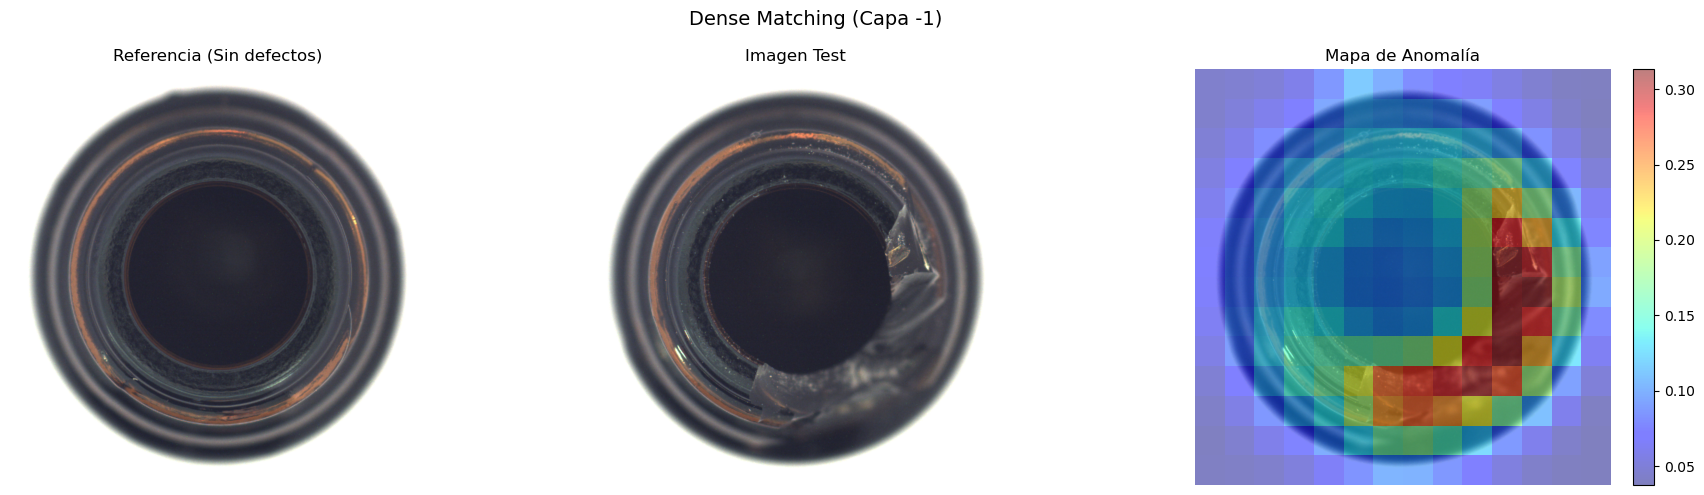


------------------------------------------------------------
MÉTODO 2: Memory Bank + k-NN (PatchCore-style)
------------------------------------------------------------

Construyendo Memory Bank...
Procesadas 10/50 imágenes
Procesadas 20/50 imágenes
Procesadas 30/50 imágenes
Procesadas 40/50 imágenes
Procesadas 50/50 imágenes
Memory Bank construido: 9800 patches, dim=768
Mapa de anomalía shape: (14, 14)
Score de imagen: 0.2739


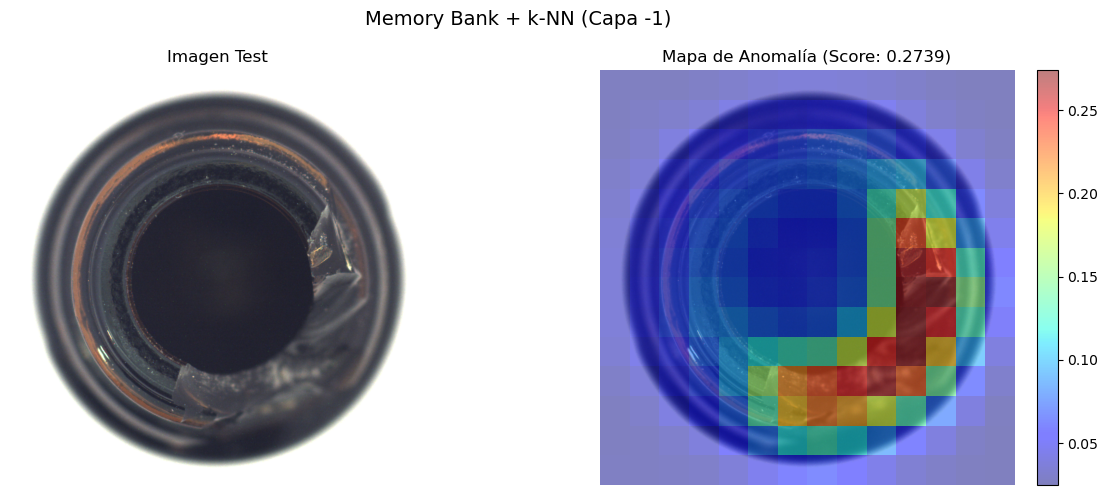


EVALUACIÓN CON GROUND TRUTH
✅ Cargados 5 pares test/GT desde broken_large/

📍 Evaluando: 000.png


/tmp/ipykernel_223885/3026641076.py:329: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  au_pro = np.trapz(pros, thresholds)


   IoU: 0.6684 | Dice: 0.8012 | F1: 0.8012 | AU-PRO: 0.7966


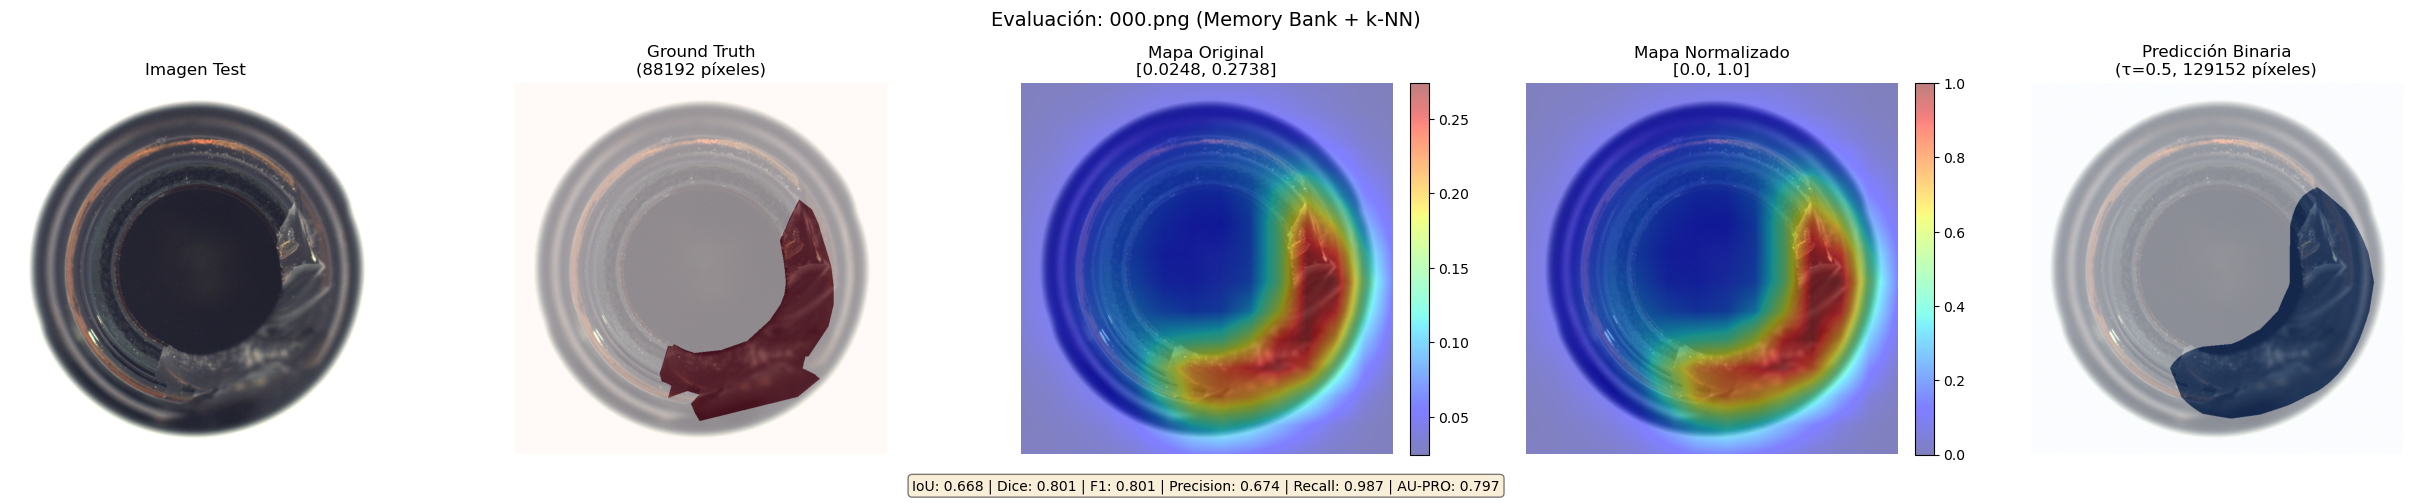


📍 Evaluando: 001.png
   IoU: 0.3977 | Dice: 0.5691 | F1: 0.5691 | AU-PRO: 0.7743

📍 Evaluando: 002.png
   IoU: 0.5462 | Dice: 0.7065 | F1: 0.7065 | AU-PRO: 0.7361

📍 Evaluando: 003.png
   IoU: 0.4563 | Dice: 0.6267 | F1: 0.6267 | AU-PRO: 0.7921

📍 Evaluando: 004.png
   IoU: 0.5853 | Dice: 0.7384 | F1: 0.7384 | AU-PRO: 0.6952

------------------------------------------------------------
RESUMEN DE MÉTRICAS
------------------------------------------------------------

Promedio sobre 5 imágenes:
  Pixel-Level:
    IoU:       0.5308
    Dice:      0.6884
    Precision: 0.5429
    Recall:    0.9701
    F1:        0.6884
  Region-Level:
    AU-PRO:    0.7589

------------------------------------------------------------
ANÁLISIS DE SENSIBILIDAD AL UMBRAL
------------------------------------------------------------

🔍 DIAGNÓSTICO DEL MAPA DE ANOMALÍA:
   Shape original: (14, 14)
   📊 Valores ORIGINALES (sin normalizar):
      Min: 0.024839
      Max: 0.273927
      Mean: 0.079923
      Std: 0

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import torch
import torch.nn.functional as F
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import scipy.ndimage as ndimage
from typing import List, Optional, Tuple, Union
from pathlib import Path
from sklearn.metrics import precision_recall_curve, auc


# =============================================================================
# FUNCIONES DE NORMALIZACIÓN Y PREPROCESAMIENTO
# =============================================================================

def normalize_anomaly_map(
    anomaly_map: np.ndarray, 
    method: str = 'minmax',
    clip_percentile: float = None
) -> np.ndarray:
    """
    Normaliza el mapa de anomalía al rango [0, 1].
    
    Args:
        anomaly_map: Mapa de anomalía sin normalizar [H, W]
        method: Método de normalización:
            - 'minmax': Normalización min-max estándar
            - 'robust': Usa percentiles para evitar outliers
        clip_percentile: Si se especifica, recorta valores extremos 
                         (ej: 1 = recorta top/bottom 1%)
    
    Returns:
        Mapa normalizado en rango [0, 1]
    """
    amap = anomaly_map.copy().astype(np.float32)
    
    # Clip de percentiles si se especifica
    if clip_percentile is not None:
        low = np.percentile(amap, clip_percentile)
        high = np.percentile(amap, 100 - clip_percentile)
        amap = np.clip(amap, low, high)
    
    if method == 'minmax':
        # Normalización min-max estándar
        min_val = amap.min()
        max_val = amap.max()
        
        if max_val - min_val > 1e-8:
            amap = (amap - min_val) / (max_val - min_val)
        else:
            # Si todos los valores son iguales, retornar ceros
            amap = np.zeros_like(amap)
    
    elif method == 'robust':
        # Normalización robusta usando percentiles 1-99
        p1 = np.percentile(amap, 1)
        p99 = np.percentile(amap, 99)
        
        if p99 - p1 > 1e-8:
            amap = (amap - p1) / (p99 - p1)
            amap = np.clip(amap, 0, 1)
        else:
            amap = np.zeros_like(amap)
    
    return amap


def resize_anomaly_map(
    anomaly_map: np.ndarray, 
    target_shape: Tuple[int, int],
    order: int = 1
) -> np.ndarray:
    """
    Redimensiona el mapa de anomalía al tamaño objetivo.
    
    Args:
        anomaly_map: Mapa de anomalía [H, W]
        target_shape: Tamaño objetivo (height, width)
        order: Orden de interpolación (0=nearest, 1=bilinear, 3=bicubic)
    
    Returns:
        Mapa redimensionado
    """
    from scipy.ndimage import zoom
    
    scale_h = target_shape[0] / anomaly_map.shape[0]
    scale_w = target_shape[1] / anomaly_map.shape[1]
    
    return zoom(anomaly_map, (scale_h, scale_w), order=order)


# =============================================================================
# FUNCIONES AUXILIARES DE CARGA DE DATOS
# =============================================================================

def load_images_from_folder(folder_path: str, n_images: Optional[int] = None) -> List[Image.Image]:
    """
    Carga imágenes desde una carpeta.
    
    Args:
        folder_path: Ruta a la carpeta con imágenes
        n_images: Número máximo de imágenes a cargar (None = todas)
        
    Returns:
        Lista de imágenes PIL en RGB
    """
    folder = Path(folder_path)
    image_extensions = {'.png', '.jpg', '.jpeg', '.bmp', '.tiff'}
    
    image_files = [f for f in folder.iterdir() 
                   if f.suffix.lower() in image_extensions]
    image_files.sort()  # Orden consistente
    
    if n_images is not None:
        image_files = image_files[:n_images]
    
    images = []
    for img_path in image_files:
        try:
            img = Image.open(img_path).convert("RGB")
            images.append(img)
        except Exception as e:
            print(f"⚠️  Error cargando {img_path.name}: {e}")
    
    print(f"✅ Cargadas {len(images)} imágenes desde {folder.name}/")
    return images


def load_test_with_ground_truth(
    test_folder: str, 
    gt_folder: str, 
    n_images: Optional[int] = None
) -> List[Tuple[Image.Image, np.ndarray, str]]:
    """
    Carga pares de imágenes test y sus ground truth masks.
    
    Args:
        test_folder: Carpeta con imágenes de test
        gt_folder: Carpeta con máscaras ground truth
        n_images: Número máximo de pares a cargar
        
    Returns:
        Lista de tuplas (test_image, gt_mask, filename)
    """
    test_path = Path(test_folder)
    gt_path = Path(gt_folder)
    
    image_extensions = {'.png', '.jpg', '.jpeg', '.bmp'}
    test_files = [f for f in test_path.iterdir() 
                  if f.suffix.lower() in image_extensions]
    test_files.sort()
    
    if n_images is not None:
        test_files = test_files[:n_images]
    
    pairs = []
    for test_file in test_files:
        # Buscar ground truth correspondiente
        gt_file = gt_path / f"{test_file.stem}_mask{test_file.suffix}"
        
        # Intentar variaciones de nombre si no existe
        if not gt_file.exists():
            gt_file = gt_path / test_file.name
        if not gt_file.exists():
            gt_file = gt_path / f"{test_file.stem}.png"
        
        if not gt_file.exists():
            print(f"⚠️  Ground truth no encontrado para {test_file.name}")
            continue
        
        try:
            test_img = Image.open(test_file).convert("RGB")
            gt_img = Image.open(gt_file).convert("L")  # Grayscale
            gt_mask = np.array(gt_img) > 127  # Binarizar
            
            pairs.append((test_img, gt_mask, test_file.name))
        except Exception as e:
            print(f"⚠️  Error cargando par {test_file.name}: {e}")
    
    print(f"✅ Cargados {len(pairs)} pares test/GT desde {test_path.name}/")
    return pairs


# =============================================================================
# EVALUADOR DE MÉTRICAS
# =============================================================================

class AnomalyEvaluator:
    """
    Evaluador de métricas para detección de anomalías.
    
    Calcula métricas pixel-level (IoU, Dice, F1, Precision, Recall)
    y region-level (AU-PRO).
    """
    
    def __init__(self, threshold: float = 0.5, auto_normalize: bool = True):
        """
        Args:
            threshold: Umbral para binarizar predicción (aplicado sobre valores [0,1])
            auto_normalize: Si True, normaliza automáticamente el mapa al rango [0,1]
        """
        self.threshold = threshold
        self.auto_normalize = auto_normalize
    
    def evaluate(
        self, 
        anomaly_map: np.ndarray, 
        gt_mask: np.ndarray,
        threshold: Optional[float] = None,
        normalize: Optional[bool] = None
    ) -> dict:
        """
        Calcula métricas de evaluación.
        
        Args:
            anomaly_map: Mapa de anomalía predicho [H, W]
            gt_mask: Máscara ground truth binaria [H, W]
            threshold: Umbral para binarizar predicción (usa self.threshold si None)
            normalize: Si True, normaliza el mapa antes de aplicar umbral.
                       Si None, usa self.auto_normalize.
            
        Returns:
            Diccionario con métricas
        """
        if threshold is None:
            threshold = self.threshold
        
        if normalize is None:
            normalize = self.auto_normalize
        
        # Guardar estadísticas originales para diagnóstico
        orig_min = anomaly_map.min()
        orig_max = anomaly_map.max()
        orig_mean = anomaly_map.mean()
        
        # Resize anomaly map al tamaño del ground truth si es necesario
        if anomaly_map.shape != gt_mask.shape:
            anomaly_map = resize_anomaly_map(anomaly_map, gt_mask.shape)
        
        # Normalizar al rango [0, 1] si está habilitado
        if normalize:
            anomaly_map = normalize_anomaly_map(anomaly_map, method='minmax')
        
        # Binarizar predicción
        pred_mask = anomaly_map >= threshold
        
        # Flatten para cálculos
        pred_flat = pred_mask.flatten()
        gt_flat = gt_mask.flatten()
        
        # Métricas pixel-level
        tp = np.sum(pred_flat & gt_flat)
        fp = np.sum(pred_flat & ~gt_flat)
        fn = np.sum(~pred_flat & gt_flat)
        tn = np.sum(~pred_flat & ~gt_flat)
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
        
        iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0.0
        dice = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0.0
        
        # AU-PRO (Area Under Per-Region Overlap) - usa mapa normalizado
        au_pro = self._compute_au_pro(anomaly_map, gt_mask)
        
        return {
            'IoU': iou,
            'Dice': dice,
            'F1': f1,
            'Precision': precision,
            'Recall': recall,
            'AU-PRO': au_pro,
            'TP': int(tp),
            'FP': int(fp),
            'FN': int(fn),
            'TN': int(tn),
            # Estadísticas para diagnóstico
            'orig_min': float(orig_min),
            'orig_max': float(orig_max),
            'orig_mean': float(orig_mean),
            'normalized': normalize
        }
    
    def _compute_au_pro(self, anomaly_map: np.ndarray, gt_mask: np.ndarray) -> float:
        """
        Calcula AU-PRO (Area Under Per-Region Overlap curve).
        
        Métrica robusta que evalúa el overlap entre predicciones y 
        regiones ground truth conectadas.
        """
        from scipy.ndimage import label
        
        # Resize si es necesario
        if anomaly_map.shape != gt_mask.shape:
            from scipy.ndimage import zoom
            scale_h = gt_mask.shape[0] / anomaly_map.shape[0]
            scale_w = gt_mask.shape[1] / anomaly_map.shape[1]
            anomaly_map = zoom(anomaly_map, (scale_h, scale_w), order=1)
        
        # Encontrar regiones conectadas en GT
        labeled_gt, num_regions = label(gt_mask)
        
        if num_regions == 0:
            return 0.0
        
        # Calcular PRO curve
        thresholds = np.linspace(0, 1, 100)
        pros = []
        
        for thresh in thresholds:
            pred_mask = anomaly_map >= thresh
            
            # Calcular overlap promedio por región
            overlaps = []
            for region_id in range(1, num_regions + 1):
                region_mask = labeled_gt == region_id
                region_size = np.sum(region_mask)
                
                if region_size > 0:
                    overlap = np.sum(pred_mask & region_mask) / region_size
                    overlaps.append(overlap)
            
            pros.append(np.mean(overlaps) if overlaps else 0.0)
        
        # Integrar curva (AU-PRO)
        au_pro = np.trapz(pros, thresholds)
        
        return au_pro
    
    def visualize_comparison(
        self,
        test_image: Image.Image,
        anomaly_map: np.ndarray,
        gt_mask: np.ndarray,
        metrics: dict,
        title: str = "Comparación: Predicción vs Ground Truth",
        show_original_values: bool = True
    ):
        """
        Visualiza predicción vs ground truth con métricas.
        
        Muestra 5 paneles:
        1. Imagen original
        2. Ground Truth
        3. Mapa original (valores sin normalizar)
        4. Mapa normalizado [0,1]
        5. Predicción binarizada
        """
        # Preparar datos
        # Resize al tamaño de la imagen para visualización
        if anomaly_map.shape != gt_mask.shape:
            amap_resized = resize_anomaly_map(anomaly_map, gt_mask.shape)
        else:
            amap_resized = anomaly_map.copy()
        
        # Guardar valores originales
        amap_original = amap_resized.copy()
        orig_min, orig_max = amap_original.min(), amap_original.max()
        
        # Normalizar
        amap_normalized = normalize_anomaly_map(amap_resized, method='minmax')
        
        # Crear figura
        n_cols = 5 if show_original_values else 4
        fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 5))
        
        ax_idx = 0
        
        # Panel 1: Imagen original
        axes[ax_idx].imshow(test_image)
        axes[ax_idx].set_title("Imagen Test")
        axes[ax_idx].axis('off')
        ax_idx += 1
        
        # Panel 2: Ground Truth
        axes[ax_idx].imshow(test_image)
        axes[ax_idx].imshow(
            resize_anomaly_map(gt_mask.astype(float), (test_image.height, test_image.width)),
            cmap='Reds', alpha=0.5,
            extent=(0, test_image.width, test_image.height, 0)
        )
        axes[ax_idx].set_title(f"Ground Truth\n({gt_mask.sum()} píxeles)")
        axes[ax_idx].axis('off')
        ax_idx += 1
        
        if show_original_values:
            # Panel 3: Mapa original (sin normalizar)
            axes[ax_idx].imshow(test_image)
            im_orig = axes[ax_idx].imshow(
                amap_original, 
                cmap='jet', 
                alpha=0.5,
                extent=(0, test_image.width, test_image.height, 0)
            )
            axes[ax_idx].set_title(f"Mapa Original\n[{orig_min:.4f}, {orig_max:.4f}]")
            axes[ax_idx].axis('off')
            plt.colorbar(im_orig, ax=axes[ax_idx], fraction=0.046, pad=0.04)
            ax_idx += 1
        
        # Panel 4: Mapa normalizado
        axes[ax_idx].imshow(test_image)
        im_norm = axes[ax_idx].imshow(
            amap_normalized, 
            cmap='jet', 
            alpha=0.5,
            vmin=0, vmax=1,
            extent=(0, test_image.width, test_image.height, 0)
        )
        axes[ax_idx].set_title(f"Mapa Normalizado\n[0.0, 1.0]")
        axes[ax_idx].axis('off')
        plt.colorbar(im_norm, ax=axes[ax_idx], fraction=0.046, pad=0.04)
        ax_idx += 1
        
        # Panel 5: Predicción binarizada
        pred_binary = amap_normalized >= self.threshold
        axes[ax_idx].imshow(test_image)
        axes[ax_idx].imshow(
            pred_binary, 
            cmap='Blues', 
            alpha=0.5,
            extent=(0, test_image.width, test_image.height, 0)
        )
        n_pred = pred_binary.sum()
        axes[ax_idx].set_title(f"Predicción Binaria\n(τ={self.threshold}, {n_pred} píxeles)")
        axes[ax_idx].axis('off')
        
        # Métricas como texto
        metrics_text = (
            f"IoU: {metrics['IoU']:.3f} | "
            f"Dice: {metrics['Dice']:.3f} | "
            f"F1: {metrics['F1']:.3f} | "
            f"Precision: {metrics['Precision']:.3f} | "
            f"Recall: {metrics['Recall']:.3f} | "
            f"AU-PRO: {metrics['AU-PRO']:.3f}"
        )
        
        plt.figtext(0.5, 0.02, metrics_text, ha='center', fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.suptitle(title, fontsize=14)
        plt.tight_layout(rect=[0, 0.06, 1, 0.96])
        plt.show()
        
        return fig


# =============================================================================
# CONFIGURACIÓN DEL MODELO
# =============================================================================
class DINOv3FeatureExtractor:
    """
    Extractor de features con DINOv3 y capa configurable.
    
    Args:
        model_path: Ruta al modelo DINOv3
        layer_idx: Índice de la capa a usar (-1 = última, 0 = embedding, etc.)
        device: Dispositivo para inferencia ('cuda' o 'cpu')
    """
    
    def __init__(self, model_path: str, layer_idx: int = -1, device: str = None):
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.processor = AutoImageProcessor.from_pretrained(model_path)
        self.model = AutoModel.from_pretrained(model_path).to(self.device)
        self.model.eval()
        self.layer_idx = layer_idx
        
        # DINOv3 típicamente usa patch_size=16 o 14
        self.patch_size = getattr(self.model.config, 'patch_size', 16)
        
        # CRÍTICO: Detectar número de register tokens
        # DINOv3 puede tener 4-6 register tokens adicionales
        self.num_register_tokens = getattr(self.model.config, 'num_register_tokens', 0)
        
        print(f"🔍 DINOv3 config: patch_size={self.patch_size}, "
              f"register_tokens={self.num_register_tokens}")
        
    def extract_patches(self, image: Image.Image, normalize: bool = True) -> torch.Tensor:
        """
        Extrae embeddings de patches de una imagen.
        
        Args:
            image: Imagen PIL
            normalize: Si True, normaliza los embeddings (L2)
            
        Returns:
            patches: Tensor [num_patches, hidden_dim]
        """
        inputs = self.processor(images=image, return_tensors="pt", do_rescale=True).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs, output_hidden_states=True)
            
            # Seleccionar capa específica
            if self.layer_idx == -1:
                hidden_states = outputs.last_hidden_state
            else:
                hidden_states = outputs.hidden_states[self.layer_idx]
            
            # Calcular número de patches espaciales
            h_feat = inputs['pixel_values'].shape[-2] // self.patch_size
            w_feat = inputs['pixel_values'].shape[-1] // self.patch_size
            num_patches = h_feat * w_feat
            
            # MÉTODO 1: Tomar últimos num_patches tokens (más robusto)
            # Esto automáticamente ignora CLS + register tokens
            patches = hidden_states[:, -num_patches:, :].squeeze(0)  # [num_patches, hidden_dim]
            
            # MÉTODO 2 (alternativo): Skip CLS + registers explícitamente
            # num_prefix_tokens = 1 + self.num_register_tokens  # CLS + registers
            # patches = hidden_states[:, num_prefix_tokens:, :].squeeze(0)
            
            if normalize:
                patches = F.normalize(patches, p=2, dim=-1)
                
        return patches
    
    def extract_patches_batch(self, images: List[Image.Image], normalize: bool = True) -> torch.Tensor:
        """
        Extrae patches de múltiples imágenes en batch.
        
        Returns:
            patches: Tensor [batch, num_patches, hidden_dim]
        """
        inputs = self.processor(images=images, return_tensors="pt", do_rescale=True).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs, output_hidden_states=True)
            
            if self.layer_idx == -1:
                hidden_states = outputs.last_hidden_state
            else:
                hidden_states = outputs.hidden_states[self.layer_idx]
            
            # Calcular número de patches
            h_feat = inputs['pixel_values'].shape[-2] // self.patch_size
            w_feat = inputs['pixel_values'].shape[-1] // self.patch_size
            num_patches = h_feat * w_feat
            
            # Extraer solo tokens espaciales (últimos num_patches)
            patches = hidden_states[:, -num_patches:, :]  # [batch, num_patches, hidden_dim]
            
            if normalize:
                patches = F.normalize(patches, p=2, dim=-1)
                
        return patches
    
    def get_grid_size(self, image: Image.Image) -> Tuple[int, int]:
        """Retorna el tamaño del grid de patches (h, w)."""
        inputs = self.processor(images=image, return_tensors="pt")
        h = inputs['pixel_values'].shape[-2] // self.patch_size
        w = inputs['pixel_values'].shape[-1] // self.patch_size
        return h, w


# =============================================================================
# MÉTODO 1: DENSE MATCHING (POSICIONAL)
# =============================================================================
class DenseMatchingDetector:
    """
    Detector de anomalías por Dense Matching (correspondencia posicional 1:1).
    
    Ideal para MVTec AD donde las imágenes están bien alineadas.
    Compara cada patch de la imagen test con el patch en la misma posición
    de la imagen de referencia.
    
    Args:
        extractor: Instancia de DINOv3FeatureExtractor
    """
    
    def __init__(self, extractor: DINOv3FeatureExtractor):
        self.extractor = extractor
        
    def compute_anomaly_map(
        self, 
        test_image: Image.Image, 
        reference_image: Image.Image,
        smooth_sigma: float = 0.8
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Calcula mapa de anomalía por comparación posicional 1:1.
        
        Args:
            test_image: Imagen a evaluar
            reference_image: Imagen de referencia (sin defectos)
            smooth_sigma: Sigma para suavizado Gaussiano
            
        Returns:
            anomaly_map: Mapa de anomalía [H, W] sin suavizar
            anomaly_map_smooth: Mapa de anomalía [H, W] suavizado
        """
        # Extraer patches de ambas imágenes
        test_patches = self.extractor.extract_patches(test_image)      # [N, D]
        ref_patches = self.extractor.extract_patches(reference_image)  # [N, D]
        
        # Similitud coseno por patch (correspondencia posicional)
        cosine_sim = (test_patches * ref_patches).sum(dim=-1)  # [N]
        
        # Anomalía = 1 - similitud
        anomaly_scores = (1 - cosine_sim).cpu().numpy()
        
        # Reshape a grid 2D
        h, w = self.extractor.get_grid_size(test_image)
        anomaly_map = anomaly_scores.reshape(h, w)
        
        # Suavizado
        anomaly_map_smooth = ndimage.gaussian_filter(anomaly_map, sigma=smooth_sigma)
        
        return anomaly_map, anomaly_map_smooth
    
    def compute_anomaly_map_multi_ref(
        self,
        test_image: Image.Image,
        reference_images: List[Image.Image],
        aggregation: str = 'min',
        smooth_sigma: float = 0.8
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Calcula mapa de anomalía contra múltiples referencias.
        
        Args:
            test_image: Imagen a evaluar
            reference_images: Lista de imágenes de referencia
            aggregation: 'min' (menor distancia) o 'mean' (promedio)
            smooth_sigma: Sigma para suavizado
            
        Returns:
            anomaly_map, anomaly_map_smooth
        """
        test_patches = self.extractor.extract_patches(test_image)  # [N, D]
        
        all_scores = []
        for ref_img in reference_images:
            ref_patches = self.extractor.extract_patches(ref_img)
            cosine_sim = (test_patches * ref_patches).sum(dim=-1)
            scores = 1 - cosine_sim
            all_scores.append(scores)
        
        all_scores = torch.stack(all_scores, dim=0)  # [num_refs, N]
        
        if aggregation == 'min':
            anomaly_scores = all_scores.min(dim=0)[0]
        else:
            anomaly_scores = all_scores.mean(dim=0)
        
        h, w = self.extractor.get_grid_size(test_image)
        anomaly_map = anomaly_scores.cpu().numpy().reshape(h, w)
        anomaly_map_smooth = ndimage.gaussian_filter(anomaly_map, sigma=smooth_sigma)
        
        return anomaly_map, anomaly_map_smooth
    
    def visualize(
        self,
        test_image: Image.Image,
        reference_image: Image.Image,
        anomaly_map: np.ndarray,
        title: str = "Dense Matching - Detección de Anomalías"
    ):
        """Visualiza resultado de detección."""
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        axes[0].imshow(reference_image)
        axes[0].set_title("Referencia (Sin defectos)")
        axes[0].axis('off')
        
        axes[1].imshow(test_image)
        axes[1].set_title("Imagen Test")
        axes[1].axis('off')
        
        axes[2].imshow(test_image)
        im = axes[2].imshow(
            anomaly_map, 
            cmap='jet', 
            alpha=0.5, 
            extent=(0, test_image.width, test_image.height, 0)
        )
        axes[2].set_title("Mapa de Anomalía")
        axes[2].axis('off')
        plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
        
        plt.suptitle(title, fontsize=14)
        plt.tight_layout()
        plt.show()
        
        return fig


# =============================================================================
# MÉTODO 2: MEMORY BANK + k-NN (PATCHCORE-STYLE)
# =============================================================================
class MemoryBankDetector:
    """
    Detector de anomalías estilo PatchCore con Memory Bank + k-NN.
    
    Estado del arte para MVTec AD. Construye un banco de memoria con
    patches de imágenes normales y detecta anomalías buscando patches
    que no tienen vecinos cercanos en el banco.
    
    Args:
        extractor: Instancia de DINOv3FeatureExtractor
        k: Número de vecinos más cercanos para scoring
        coreset_ratio: Ratio de subsampling del memory bank (1.0 = sin subsampling)
    """
    
    def __init__(
        self, 
        extractor: DINOv3FeatureExtractor, 
        k: int = 1,
        coreset_ratio: float = 1.0
    ):
        self.extractor = extractor
        self.k = k
        self.coreset_ratio = coreset_ratio
        self.memory_bank = None
        
    def build_memory_bank(self, good_images: List[Image.Image], verbose: bool = True):
        """
        Construye el banco de memoria con patches de imágenes sin defectos.
        
        Args:
            good_images: Lista de imágenes PIL sin defectos (training set)
            verbose: Si True, muestra progreso
        """
        all_patches = []
        
        for i, img in enumerate(good_images):
            patches = self.extractor.extract_patches(img)  # [N, D]
            all_patches.append(patches)
            
            if verbose and (i + 1) % 10 == 0:
                print(f"Procesadas {i + 1}/{len(good_images)} imágenes")
        
        # Concatenar todos los patches
        self.memory_bank = torch.cat(all_patches, dim=0)  # [total_patches, D]
        
        # Coreset subsampling (opcional, para reducir memoria)
        if self.coreset_ratio < 1.0:
            n_samples = int(len(self.memory_bank) * self.coreset_ratio)
            indices = torch.randperm(len(self.memory_bank))[:n_samples]
            self.memory_bank = self.memory_bank[indices]
        
        if verbose:
            print(f"Memory Bank construido: {self.memory_bank.shape[0]} patches, "
                  f"dim={self.memory_bank.shape[1]}")
    
    def compute_anomaly_map(
        self, 
        test_image: Image.Image,
        smooth_sigma: float = 0.8
    ) -> Tuple[np.ndarray, np.ndarray, float]:
        """
        Calcula mapa de anomalía comparando contra memory bank.
        
        Args:
            test_image: Imagen a evaluar
            smooth_sigma: Sigma para suavizado
            
        Returns:
            anomaly_map: Mapa [H, W] sin suavizar
            anomaly_map_smooth: Mapa [H, W] suavizado
            image_score: Score de anomalía a nivel de imagen
        """
        if self.memory_bank is None:
            raise RuntimeError("Primero ejecuta build_memory_bank()")
        
        # Extraer patches de imagen test
        test_patches = self.extractor.extract_patches(test_image)  # [N, D]
        
        # Calcular similitud con todo el memory bank
        # sim[i, j] = similitud entre test_patch[i] y memory_patch[j]
        sim_matrix = torch.mm(test_patches, self.memory_bank.t())  # [N, memory_size]
        
        # k-NN: obtener k vecinos más similares
        topk_sim, _ = sim_matrix.topk(self.k, dim=1)  # [N, k]
        
        # Anomalía = 1 - similitud promedio de k vecinos
        anomaly_scores = 1 - topk_sim.mean(dim=1)  # [N]
        
        # Reshape a grid 2D
        h, w = self.extractor.get_grid_size(test_image)
        anomaly_map = anomaly_scores.cpu().numpy().reshape(h, w)
        
        # Suavizado
        anomaly_map_smooth = ndimage.gaussian_filter(anomaly_map, sigma=smooth_sigma)
        
        # Score a nivel de imagen (máximo score de anomalía)
        image_score = anomaly_map_smooth.max()
        
        return anomaly_map, anomaly_map_smooth, image_score
    
    def predict_batch(
        self,
        test_images: List[Image.Image],
        smooth_sigma: float = 0.8
    ) -> Tuple[List[np.ndarray], List[float]]:
        """
        Predice anomalías para un batch de imágenes.
        
        Returns:
            anomaly_maps: Lista de mapas de anomalía
            image_scores: Lista de scores por imagen
        """
        anomaly_maps = []
        image_scores = []
        
        for img in test_images:
            _, amap_smooth, score = self.compute_anomaly_map(img, smooth_sigma)
            anomaly_maps.append(amap_smooth)
            image_scores.append(score)
        
        return anomaly_maps, image_scores
    
    def visualize(
        self,
        test_image: Image.Image,
        anomaly_map: np.ndarray,
        image_score: float,
        title: str = "Memory Bank + k-NN - Detección de Anomalías"
    ):
        """Visualiza resultado de detección."""
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        axes[0].imshow(test_image)
        axes[0].set_title("Imagen Test")
        axes[0].axis('off')
        
        axes[1].imshow(test_image)
        im = axes[1].imshow(
            anomaly_map, 
            cmap='jet', 
            alpha=0.5, 
            extent=(0, test_image.width, test_image.height, 0)
        )
        axes[1].set_title(f"Mapa de Anomalía (Score: {image_score:.4f})")
        axes[1].axis('off')
        plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
        
        plt.suptitle(title, fontsize=14)
        plt.tight_layout()
        plt.show()
        
        return fig


# =============================================================================
# MAIN
# =============================================================================
if __name__ == "__main__":
    
    # =========================================================================
    # CONFIGURACIÓN
    # =========================================================================
    MODEL_PATH = '/home/bllancao/Portafolio/mvtec_anomaly_detection/models/dinov3-vitb16-pretrain-lvd1689m'
    LAYER_IDX = -1  # -1 = última capa, 11 = penúltima, etc.
    
    # Carpeta con imágenes "good" para el memory bank
    GOOD_FOLDER = "/home/bllancao/Portafolio/mvtec_anomaly_detection/data/raw/bottle/train/good"
    N_GOOD_IMAGES = 50  # Número de imágenes "good" a cargar (None = todas)
    
    # Imagen de test (con defecto)
    TEST_IMAGE_PATH = "/home/bllancao/Portafolio/mvtec_anomaly_detection/data/raw/bottle/test/broken_large/000.png"
    
    # =========================================================================
    # CARGA DE IMÁGENES
    # =========================================================================
    
    # Cargar imágenes "good" automáticamente
    good_images = load_images_from_folder(GOOD_FOLDER, n_images=N_GOOD_IMAGES)
    
    # Usar la primera imagen "good" como referencia para Dense Matching
    image_good = good_images[0]
    
    # Cargar imagen de test
    image_broken = Image.open(TEST_IMAGE_PATH).convert("RGB")
    
    print("=" * 60)
    print("MVTec AD Anomaly Detection con DINOv3")
    print("=" * 60)
    
    # Crear extractor con capa configurable
    extractor = DINOv3FeatureExtractor(
        model_path=MODEL_PATH,
        layer_idx=LAYER_IDX
    )
    print(f"\nExtractor creado - Capa: {LAYER_IDX}, Device: {extractor.device}")
    
    # -------------------------------------------------------------------------
    # MÉTODO 1: Dense Matching
    # -------------------------------------------------------------------------
    print("\n" + "-" * 60)
    print("MÉTODO 1: Dense Matching (Posicional)")
    print("-" * 60)
    
    dense_detector = DenseMatchingDetector(extractor)
    
    # Calcular mapa de anomalía
    amap_dense, amap_dense_smooth = dense_detector.compute_anomaly_map(
        test_image=image_broken,
        reference_image=image_good
    )
    
    print(f"Mapa de anomalía shape: {amap_dense.shape}")
    print(f"Score máximo: {amap_dense_smooth.max():.4f}")
    
    # Visualizar
    dense_detector.visualize(
        test_image=image_broken,
        reference_image=image_good,
        anomaly_map=amap_dense_smooth,
        title=f"Dense Matching (Capa {LAYER_IDX})"
    )
    
    # -------------------------------------------------------------------------
    # MÉTODO 2: Memory Bank + k-NN
    # -------------------------------------------------------------------------
    print("\n" + "-" * 60)
    print("MÉTODO 2: Memory Bank + k-NN (PatchCore-style)")
    print("-" * 60)
    
    memory_detector = MemoryBankDetector(
        extractor=extractor,
        k=1,  # k vecinos más cercanos
        coreset_ratio=1.0  # Sin subsampling
    )
    
    # Construir memory bank con las imágenes cargadas
    print("\nConstruyendo Memory Bank...")
    memory_detector.build_memory_bank(good_images, verbose=True)
    
    # Calcular mapa de anomalía
    amap_memory, amap_memory_smooth, image_score = memory_detector.compute_anomaly_map(
        test_image=image_broken
    )
    
    print(f"Mapa de anomalía shape: {amap_memory.shape}")
    print(f"Score de imagen: {image_score:.4f}")
    
    # Visualizar
    memory_detector.visualize(
        test_image=image_broken,
        anomaly_map=amap_memory_smooth,
        image_score=image_score,
        title=f"Memory Bank + k-NN (Capa {LAYER_IDX})"
    )
    
    # =========================================================================
    # EVALUACIÓN CON GROUND TRUTH
    # =========================================================================
    print("\n" + "=" * 60)
    print("EVALUACIÓN CON GROUND TRUTH")
    print("=" * 60)
    
    # Configuración de carpetas de test y ground truth
    TEST_FOLDER = "/home/bllancao/Portafolio/mvtec_anomaly_detection/data/raw/bottle/test/broken_large"
    GT_FOLDER = "/home/bllancao/Portafolio/mvtec_anomaly_detection/data/raw/bottle/ground_truth/broken_large"
    ANOMALY_THRESHOLD = 0.5  # Umbral para binarizar la predicción
    N_TEST_IMAGES = 5  # Número de imágenes a evaluar (None = todas)
    
    # Cargar pares test/ground_truth
    test_data = load_test_with_ground_truth(
        test_folder=TEST_FOLDER,
        gt_folder=GT_FOLDER,
        n_images=N_TEST_IMAGES
    )
    
    # Crear evaluador
    evaluator = AnomalyEvaluator(threshold=ANOMALY_THRESHOLD)
    
    # Evaluar cada imagen
    all_metrics = []
    
    for test_img, gt_mask, filename in test_data:
        print(f"\n📍 Evaluando: {filename}")
        
        # Calcular mapa de anomalía con Memory Bank
        amap, amap_smooth, score = memory_detector.compute_anomaly_map(test_img)
        
        # Evaluar métricas
        metrics = evaluator.evaluate(amap_smooth, gt_mask, threshold=ANOMALY_THRESHOLD)
        metrics['filename'] = filename
        metrics['image_score'] = score
        all_metrics.append(metrics)
        
        # Mostrar métricas
        print(f"   IoU: {metrics['IoU']:.4f} | Dice: {metrics['Dice']:.4f} | "
              f"F1: {metrics['F1']:.4f} | AU-PRO: {metrics['AU-PRO']:.4f}")
        
        # Visualizar (solo primera imagen como ejemplo)
        if filename == test_data[0][2]:
            evaluator.visualize_comparison(
                test_image=test_img,
                anomaly_map=amap_smooth,
                gt_mask=gt_mask,
                metrics=metrics,
                title=f"Evaluación: {filename} (Memory Bank + k-NN)"
            )
    
    # -------------------------------------------------------------------------
    # Resumen de métricas
    # -------------------------------------------------------------------------
    print("\n" + "-" * 60)
    print("RESUMEN DE MÉTRICAS")
    print("-" * 60)
    
    # Calcular promedios
    avg_iou = np.mean([m['IoU'] for m in all_metrics])
    avg_dice = np.mean([m['Dice'] for m in all_metrics])
    avg_f1 = np.mean([m['F1'] for m in all_metrics])
    avg_precision = np.mean([m['Precision'] for m in all_metrics])
    avg_recall = np.mean([m['Recall'] for m in all_metrics])
    avg_au_pro = np.mean([m['AU-PRO'] for m in all_metrics])
    
    print(f"\nPromedio sobre {len(all_metrics)} imágenes:")
    print(f"  Pixel-Level:")
    print(f"    IoU:       {avg_iou:.4f}")
    print(f"    Dice:      {avg_dice:.4f}")
    print(f"    Precision: {avg_precision:.4f}")
    print(f"    Recall:    {avg_recall:.4f}")
    print(f"    F1:        {avg_f1:.4f}")
    print(f"  Region-Level:")
    print(f"    AU-PRO:    {avg_au_pro:.4f}")
    
    # -------------------------------------------------------------------------
    # Análisis de sensibilidad al umbral
    # -------------------------------------------------------------------------
    print("\n" + "-" * 60)
    print("ANÁLISIS DE SENSIBILIDAD AL UMBRAL")
    print("-" * 60)
    
    thresholds_to_test = [0.3, 0.4, 0.5, 0.6, 0.7]
    
    # Usar primera imagen como ejemplo
    test_img, gt_mask, filename = test_data[0]
    amap, amap_smooth, _ = memory_detector.compute_anomaly_map(test_img)
    

    print("\n🔍 DIAGNÓSTICO DEL MAPA DE ANOMALÍA:")
    print(f"   Shape original: {amap_smooth.shape}")
    print(f"   📊 Valores ORIGINALES (sin normalizar):")
    print(f"      Min: {amap_smooth.min():.6f}")
    print(f"      Max: {amap_smooth.max():.6f}")
    print(f"      Mean: {amap_smooth.mean():.6f}")
    print(f"      Std: {amap_smooth.std():.6f}")
    
    # Normalizar y resize al tamaño del GT
    amap_resized = resize_anomaly_map(amap_smooth, gt_mask.shape)
    amap_normalized = normalize_anomaly_map(amap_resized, method='minmax')
    
    print(f"\n   📊 Valores NORMALIZADOS [0, 1]:")
    print(f"      Shape (resized): {amap_normalized.shape}")
    print(f"      Min: {amap_normalized.min():.6f}")
    print(f"      Max: {amap_normalized.max():.6f}")
    print(f"      Mean: {amap_normalized.mean():.6f}")
    print(f"      Std: {amap_normalized.std():.6f}")
    print(f"   Umbral usado: {ANOMALY_THRESHOLD}")

    # Verificar cuántos píxeles superan el umbral (sobre valores normalizados)
    pred_mask = amap_normalized >= ANOMALY_THRESHOLD
    print(f"\n   ✅ Píxeles predichos como anomalía (normalizado): {pred_mask.sum()} / {pred_mask.size}")
    print(f"   Porcentaje: {100 * pred_mask.sum() / pred_mask.size:.2f}%")

    print(f"\n🎯 GROUND TRUTH:")
    print(f"   Shape: {gt_mask.shape}")
    print(f"   Píxeles anómalos en GT: {gt_mask.sum()} / {gt_mask.size}")
    print(f"   Porcentaje: {100 * gt_mask.sum() / gt_mask.size:.2f}%")

    print(f"\nImagen: {filename}")
    print(f"{'Umbral':<10} {'IoU':<10} {'Dice':<10} {'F1':<10} {'Precision':<10} {'Recall':<10}")
    print("-" * 60)
    
    for thresh in thresholds_to_test:
        metrics = evaluator.evaluate(amap_smooth, gt_mask, threshold=thresh)
        print(f"{thresh:<10.2f} {metrics['IoU']:<10.4f} {metrics['Dice']:<10.4f} "
              f"{metrics['F1']:<10.4f} {metrics['Precision']:<10.4f} {metrics['Recall']:<10.4f}")
    
    print("\n✅ Ejecución completada")